In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
from keras.preprocessing.text import Tokenizer
from PIL import Image
import numpy as np 
import pandas as pd 
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.layers import Conv1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import (LSTM, Embedding, BatchNormalization,Dense,
                          TimeDistributed, Dropout, Bidirectional,Flatten, GlobalMaxPool1D)
!pip install keras-visualizer

from keras_visualizer import visualizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/gloves-100-d/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


* [Introduction](#Introduction)
    
* [EDA](#EDA)
   
* [Visualizations](#Visualizations) 

* [Data_Cleaning](#Data_Cleaning)

* [Processing_Word_Embedding](#Processing_Word_Embedding)
* [Model_Selection](#Model_Selection)

* [Results](#Results)

# *_Disaster tweets project using LSTM_* <a class="anchor"  id="Introduction"></a>  <a class="anchor"  id="subsection1"></a>

##### This project uses an introductory dataset from Kaggle.com about sentiment analysis of Tweets.
##### The tweets are split into two categories, either "Disaster" or "Not Disaster".
##### And the goal is to train an unsupervised learning algorithm to classify tweets based on text into either category.

## Data set Description:

##### Each sample in the train and text set of csv samples contains :
##### * ` text ` of each tweet , `keyword` and `location` 
##### Each may contain NaN values, symbols, emojis, or be blank. 
##### The `train` dataset contains 6801 rows. and the `test` contains 

## The goals
##### * To perform sucessful data cleanup to provide the best overall model performance possible.
##### * To train a model to predict whether a tweet falls into category 1 or 0 based on the contents of the `text` column in either data set. 




## Loading Data and basic EDA <a class="anchor"  id="EDA"></a>  <a class="anchor"  id="subsection1"></a>

#####  The data is loaded and inspected. There are several columns that will be dropped or ignored. The `id`, `keyword` and `location` columns. 
##### Additionally the text column could use quite a bit of cleanup. ##### Additionally the text column could use quite a bit of cleanup. 

In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [4]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [91]:
len(df_test)

3263

# Visualizations <a class="anchor"  id="Visualizations"></a>  <a class="anchor"  id="subsection1"></a><a class="anchor"  id="EDA"></a>  <a class="anchor"  id="subsection1"></a>

##### 

(6800.0, 8000.0)

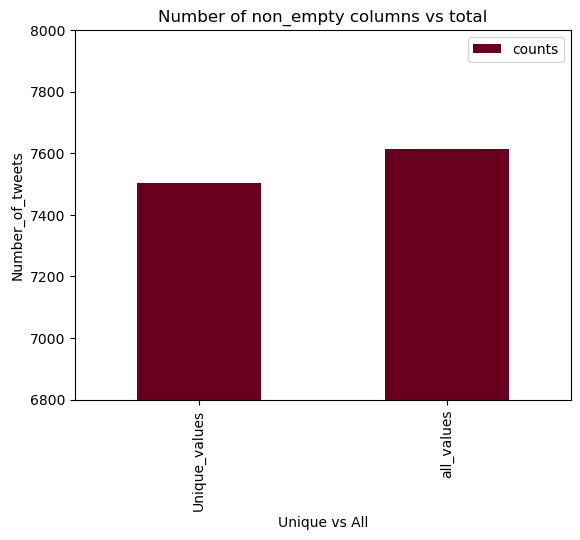

In [5]:
uniques = len(df_train['text'].unique())
entirething = (len(df_train['text']))
uniques = np.array(uniques)
entirething = np.array(entirething)
plotters = pd.DataFrame([uniques,entirething],columns =['counts'])
plotters['name'] = ['Unique_values','all_values']
plotters.plot.bar(x = 'name', y = ['counts'],title ="Number of non_empty columns vs total",colormap ='RdBu',ylabel = "Number_of_tweets",xlabel= 'Unique vs All')
plt.ylim(6800,8000)

#### The number of unique texts VS the actual count of tweets above is an indicator that there may be some duplicate columns. Those will be addressed. 

In [6]:
def create_corpus(target):
    corpus=[]
    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

/tmp/ipykernel_32/4207499841.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='pink')
/tmp/ipykernel_32/4207499841.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')


Text(0.5, 0.98, 'Average word length in each tweet')

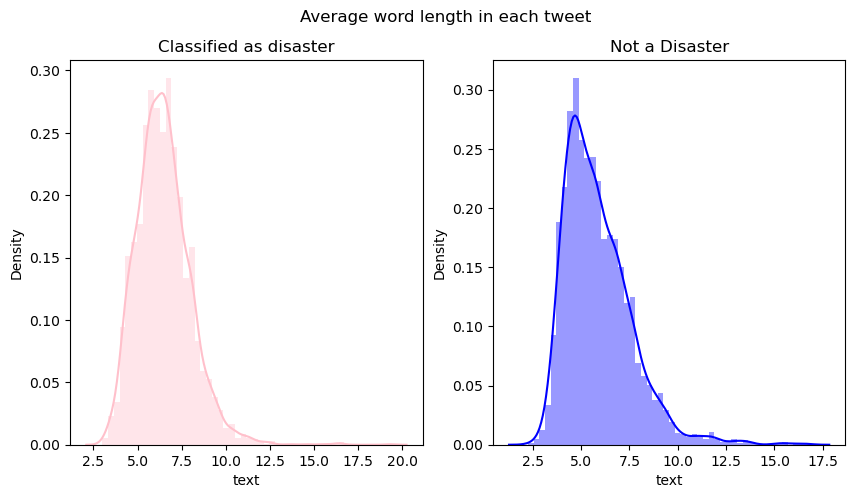

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='pink')
ax1.set_title('Classified as disaster')
word = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_title('Not a Disaster')
fig.suptitle('Average word length in each tweet')

##### The lengths of tweets that are classified as disasters is on average a bit shorter than those not classified as disasters.
##### There could be many reasons for this, it was just an interesting note.

Text(0.5, 1.0, 'Common stop words in tweets')

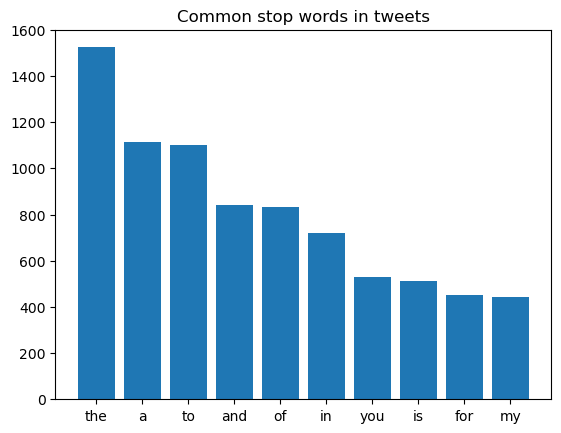

In [8]:
stop = set(stopwords.words('english'))

corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] +=1
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.title("Common stop words in tweets")

In [56]:
tweets = df_train.loc[df_train['target'] == 0]
tweets1 = tweets['text']
tweets2 = df_train.loc[df_train['target'] == 1]
tweets3 = tweets2['text']

##### The above bar graph shows the count of common stop words which will hopefully be filtered out using the stop words command. 
##### The reasoning behind this is it improves results for text classification and sentiment analysis. 
https://www.kaggle.com/discussions/general/208662

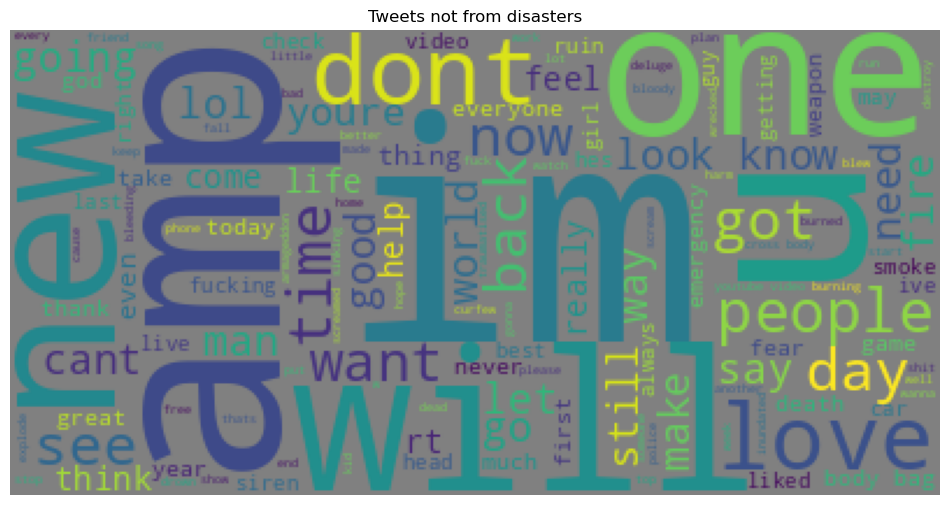

In [55]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wc = WordCloud(
    background_color='gray', 
    max_words=200)
    
    

wc.generate(' '.join(text for text in tweets1))
plt.figure(figsize=(12,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 10,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.title("Tweets not from disasters")
plt.set_cmap("cubehelix")
plt.show()

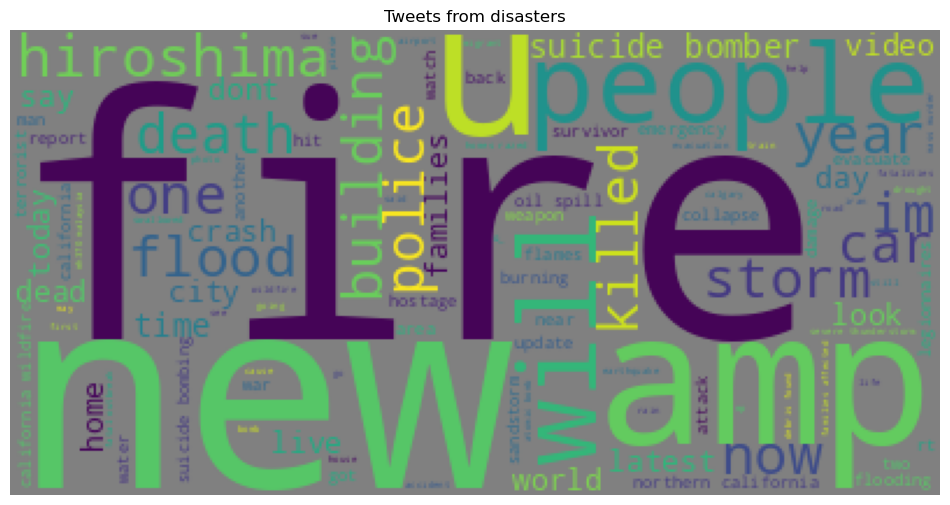

In [72]:
wc = WordCloud(
    background_color='gray', 
    max_words=200)
    
    

wc.generate(' '.join(text for text in tweets3))
plt.figure(figsize=(12,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 10,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.title("Tweets from disasters")
plt.set_cmap("cubehelix")
plt.show()

# Data Cleanup <a class="anchor"  id="Data_Cleaning"></a>

# Checking for duplicates
##### Code used:  DataFrame.drop_duplicates(subset=None, *, keep='first', inplace=False, ignore_index=False)
##### Straighforward just use the duplicated command. There are 702 rows that are classified as duplicates, and to remove them is as simple as df.drop.
##### The table below shows not only the duplicate rows but also some empty rows, which will be quickly removed using this command. 



|     |   id | keyword             | location                     | text                                                                                                          |   target | Tokenized                                                                                                                                                         |
|----:|-----:|:--------------------|:-----------------------------|:--------------------------------------------------------------------------------------------------------------|---------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  59 |   83 | ablaze              | Edmonton, Alberta - Treaty 6 | how the west was burned thousands of wildfires ablaze in california alone                                     |        1 | ['how', 'the', 'west', 'was', 'burned', 'thousands', 'of', 'wildfires', 'ablaze', 'in', 'california', 'alone']                                                    |
| 106 |  156 | aftershock          | US                           | 320 ir icemoon aftershock                                                                                     |        0 | ['320', 'ir', 'icemoon', 'aftershock']                                                                                                                            |
| 114 |  164 | aftershock          | Switzerland                  | 320 ir icemoon aftershock                                                                                     |        0 | ['320', 'ir', 'icemoon', 'aftershock']                                                                                                                            |
| 116 |  168 | aftershock          | nan                          | 320 ir icemoon aftershock                                                                                     |        0 | ['320', 'ir', 'icemoon', 'aftershock']                                                                                                                            |
| 118 |  171 | aftershock          | Switzerland                  | 320 ir icemoon aftershock                                                                                     |        0 | ['320', 'ir', 'icemoon', 'aftershock']                                                                                                                            |
| 131 |  190 | aftershock          | nan                          | aftershock                                                                                                    |        0 | ['aftershock']                                                                                                                                                    |
| 159 |  229 | airplane%20accident | nan                          | experts in france begin examining airplane debris found on reunion island french air accident experts on wedn |        1 | ['experts', 'in', 'france', 'begin', 'examining', 'airplane', 'debris', 'found', 'on', 'reunion', 'island', 'french', 'air', 'accident', 'experts', 'on', 'wedn'] |
| 172 |  247 | ambulance           | Jackson                      |                                                                                                               |        1 | []                                                                                                                                                                |
| 183 |  262 | ambulance           | Amsterdam                    |                                                                                                               |        1 | []                                                                                                                                                                |
| 186 |  265 | ambulance           | Happily Married with 2 kids  | ambulance sprinter automatic frontline vehicle choice of 14 lez compliant  ebay                               |        0 | ['ambulance', 'sprinter', 'automatic', 'frontline', 'vehicle', 'choice', 'of', '14', 'lez', 'compliant', 'ebay']   

In [82]:
duplicate = df_train[df_train.duplicated('text')]
df_train = df_train.drop_duplicates('text')
len(duplicate)

702

## Cleaning up Data using regex

##### Using the re.sub command emojis, non letter characters and webpages were removed. The data was also changed to all lowercase. 
##### This was done in order to apply a tokenizer properly, which is the first step in natural language processing.

In [11]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df_train['text']=df_train['text'].apply(lambda x: remove_emoji(x))
df_test['text']=df_test['text'].apply(lambda x: remove_emoji(x))

In [18]:
df_train['text'] = df_train['text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
df_train['text'] = df_train['text'].apply(lambda row: re.sub(r'http(.*)\S', '', row))
df_test['text'] = df_test['text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
df_test['text'] = df_test['text'].apply(lambda row: re.sub(r'http(.*)\S', '', row))
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wc = WordCloud(
    background_color='gray', 
    max_words=200)
    
    

wc.generate(' '.join(text for text in tweets1))
plt.figure(figsize=(12,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 10,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.title("Tweets not from disasters after cleanup")
plt.set_cmap("cubehelix")
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wc = WordCloud(
    background_color='gray', 
    max_words=200)
    
    

wc.generate(' '.join(text for text in tweets1))
plt.figure(figsize=(12,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 10,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.title("Tweets not from disasters, after cleanup")
plt.set_cmap("cubehelix")
plt.show()

## Splitting the data by values for further processing. Word embedding <a class="anchor"  id="Processing_Word_Embedding"></a><a class="anchor"  id="Data_Cleaning"></a>

##### The algorithm I used was GloVe which does just that. It takes word-word co occurences from a corpus (which is a collection of data used to train AI) and matches the words I give it to that. Making a giant word ##### net. https://nlp.stanford.edu/projects/glove/
##### A pretrained word vector was used, the Wikipedia 2014 Gigaword file. 
##### For proper transformation I needed just the raw values from each df. I then applied tokenization using the Tokenize function. 
##### The `texts to sequences` function transforms each text into a sequence of integers, then it gets padded with 0s so all are equally sized.And added to a word embedding dictionary.
##### A word embedding dictionary should have each word and then a numerical value associated with it. Below is the final set of vectors.



[  27  845    2 ...    0    0    0] <br>
[ 410   50  319 ...    0    0    0] <br>
[  71    8    2 ...    0    0    0] <br>
[ 885  696  469 ...    0    0    0] <br>
[5944  533  650 ...    0    0    0] <br>
[5637   44 2617 ...    0    0    0] <br>


In [19]:
df_train1= df_train.text.values
df_test1 = df_test.text.values
sentiments = df_train.target.values

In [66]:
import nltk
from nltk.stem import WordNetLemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def tokenize(text):
    return [w for w in w_tokenizer.tokenize(text)]
df_train["Tokenized"] = df_train["text"].apply(tokenize)

In [67]:
df_train['Tokenized']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [13000, people, receive, wildfires, evacuation...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7604    [worldnews, fallen, powerlines, on, glink, tra...
7605    [on, the, flip, side, im, at, walmart, and, th...
7606    [suicide, bomber, kills, 15, in, saudi, securi...
7608    [two, giant, cranes, holding, a, bridge, colla...
7612    [the, latest, more, homes, razed, by, northern...
Name: Tokenized, Length: 7503, dtype: object

In [20]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(df_train1)
vocab_length = len(word_tokenizer.word_index) + 1

In [21]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [22]:
len(df_test)

3263

In [23]:
longest_train = max(df_train1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(df_train1), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(df_test1), 
    length_long_sentence,
    padding='post'
)

In [102]:
print(test_sentences)

[[  27  845    2 ...    0    0    0]
 [ 410   50  319 ...    0    0    0]
 [  71    8    2 ...    0    0    0]
 ...
 [ 885  696  469 ...    0    0    0]
 [5944  533  650 ...    0    0    0]
 [5637   44 2617 ...    0    0    0]]


In [24]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/kaggle/input/gloves-100-d/glove.6B.100d.txt','r')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=0.15
)

## Model Selection, and hyperparameter tuning: <a class="anchor"  id="Model_Selection"><a class="anchor"  id="Processing_Word_Embedding">


##### The model I chose was the Bidirectional LSTM.
##### Which stands for Long Short Term memory. 
##### Bidirectional LSTM or BiLSTM is a term used for a sequence model which contains two 
##### LSTM layers, one for processing input in the forward direction and the other for processing in the backward direction. 
##### It is usually used in NLP-related tasks. The intuition behind this approach is that by processing data in both directions, 
##### the model is able to better understand the relationship between sequences (e.g. knowing the following and preceding words in a sentence).*https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/#

##### The model Architecture: 
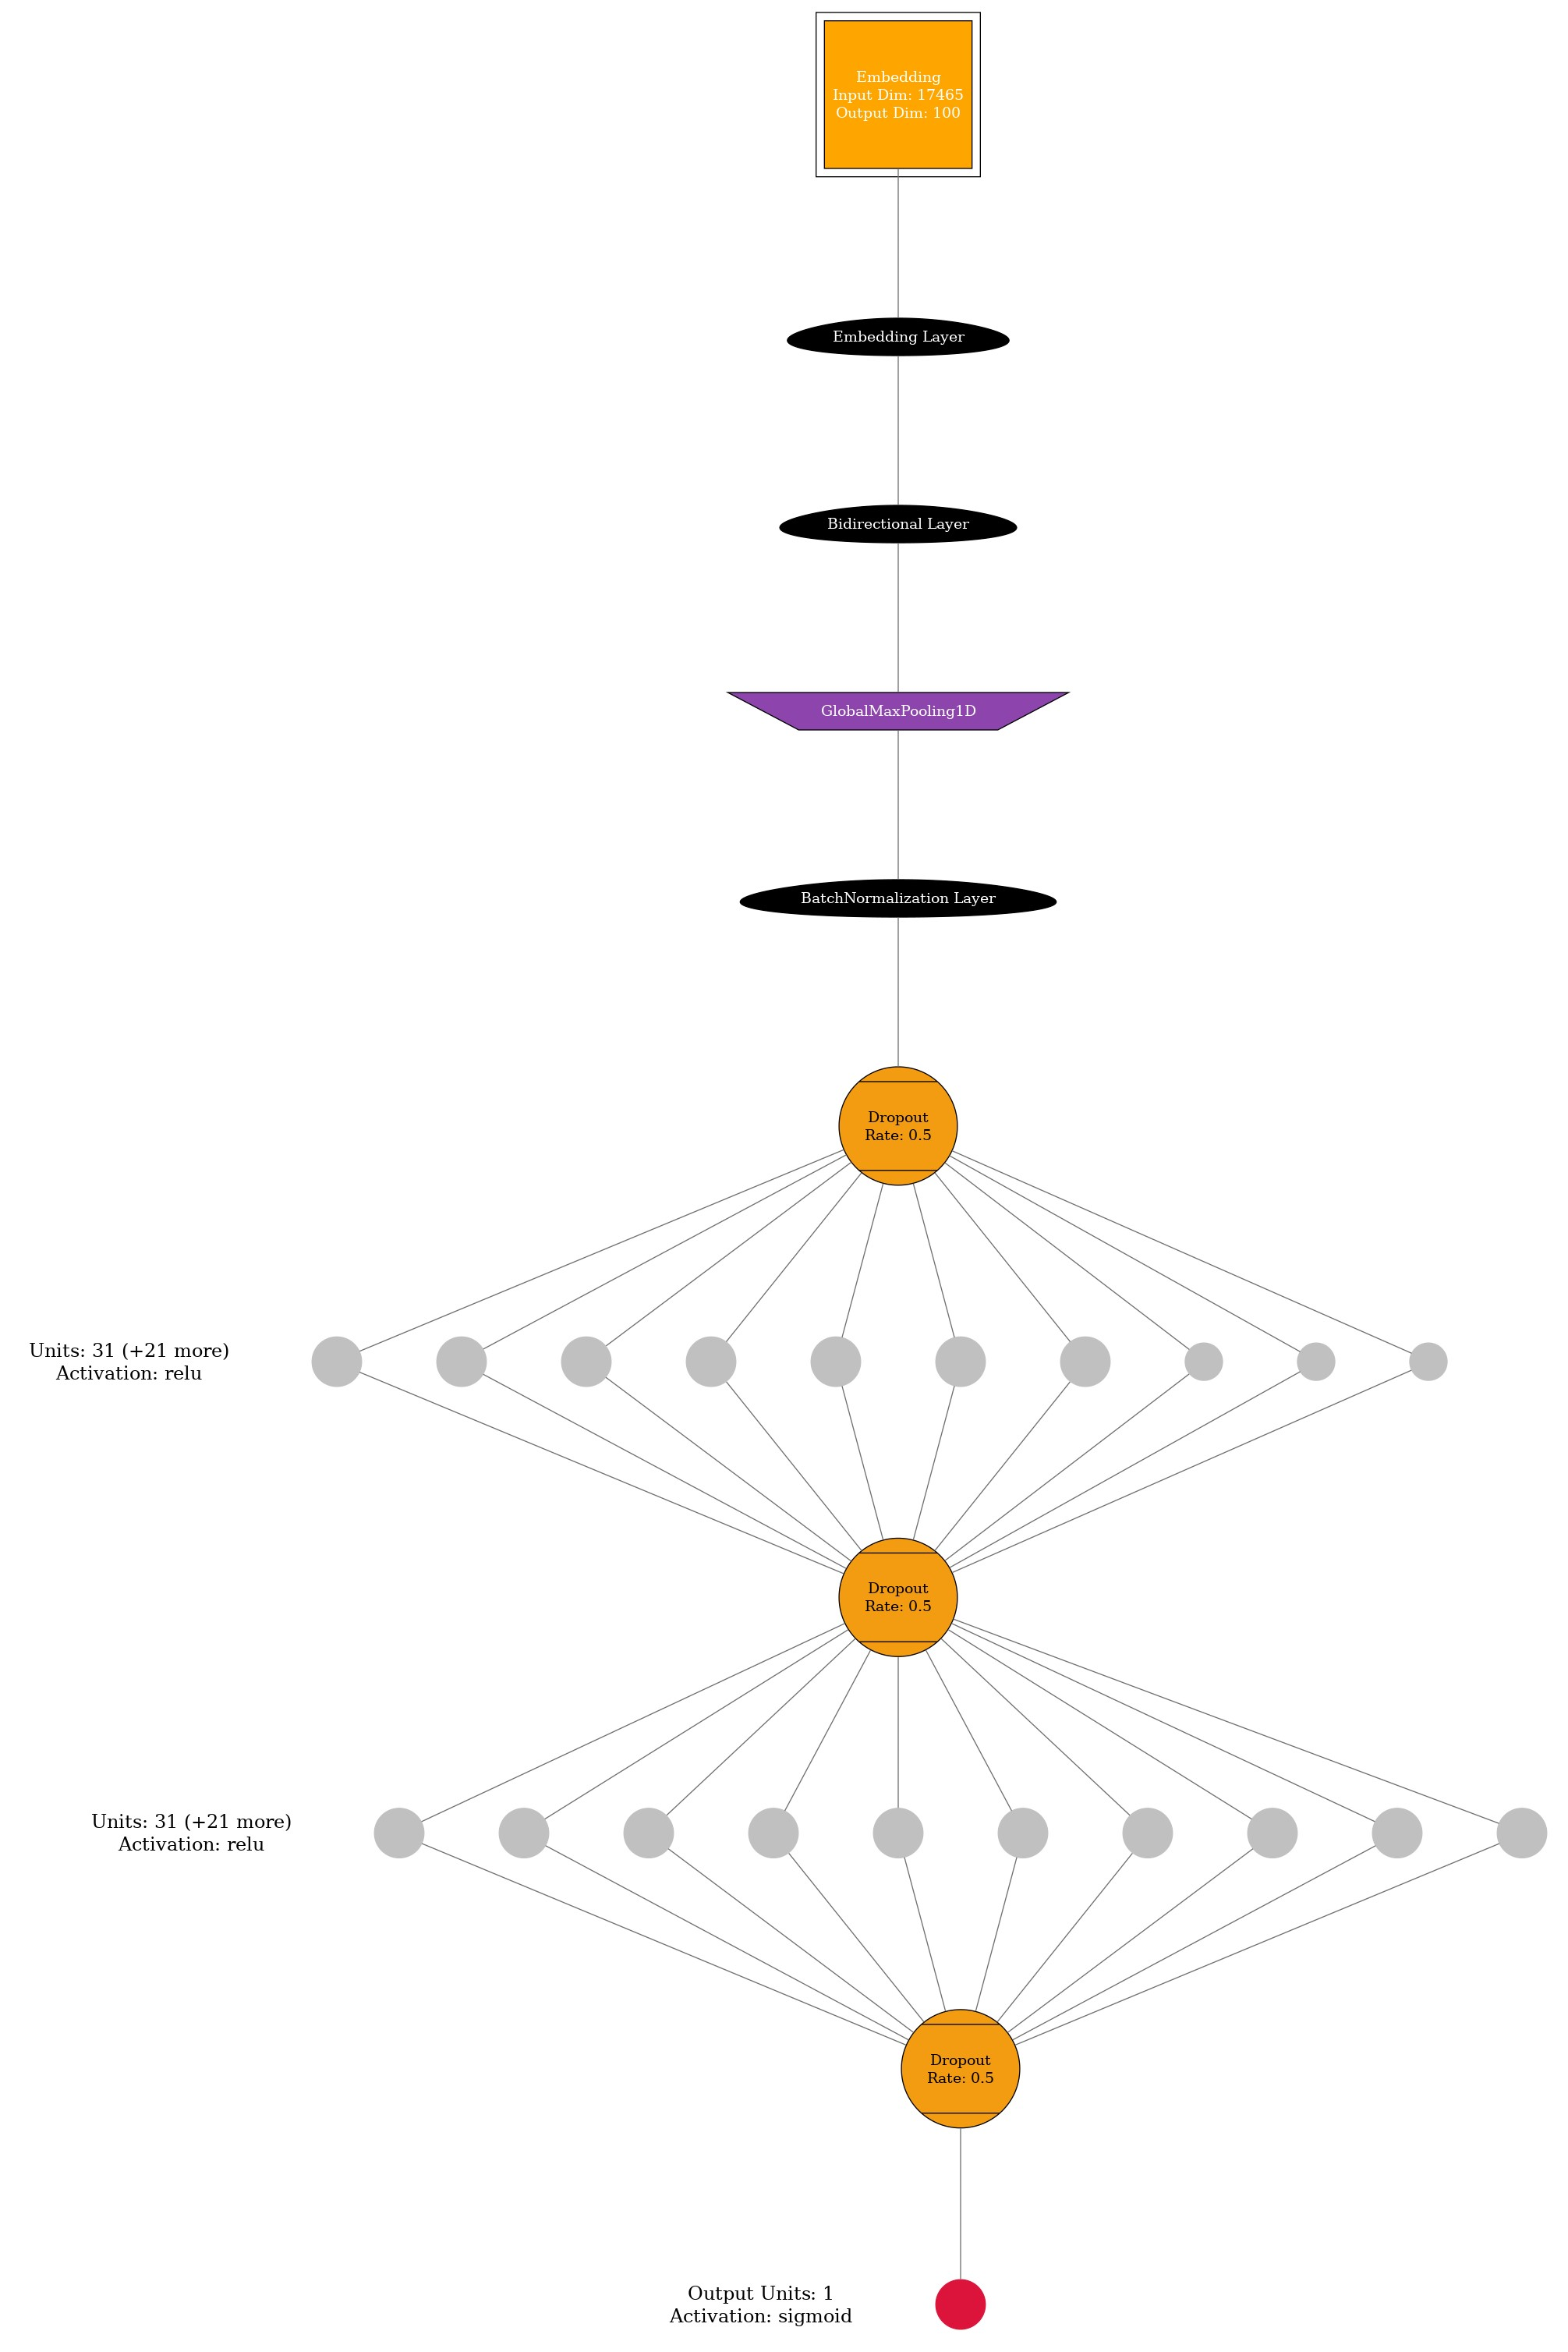




<div class="alert alert-block alert-info">

<b>## Model Params :</b>  Since the class mode is binary, a sequential model is appropriate. 

Learning rate: Learning rate is dynamic, with the implementation of ReduceLRonplateu function. It can adapt to be faster or slower.

The Optimizer I am using is rmsprop. 

The dropout rate is 0.3, and 0.5 respectively.
The loss function is binary crossentropy.
Since the class mode is binary, a sequential model is appropriate. 

Learning rate: Learning rate is dynamic, with the implementation of ReduceLRonplateu function. It can adapt to be faster or slower.

The Optimizer I am using is rmsprop. According to the docs it maintains a moving average of the square of the gradients.

* The dropout rate is 0.3, and 0.5 respectively.

* The loss function is binary crossentropy.


* Conv2D :  Convolutes the matrix, reshaping it. Each layer receives only a small portion of the outputs of the previous layer.

* Global Max pool: Pools together all of the previous outputs.*

* Normalization: Transforms the output, maintaining the mean output close to 0 and the standard deviation close to 1. *

* Dropout- Inputs randomly get set to 0 at a probability/frequency of the set rate. 

* Dense: Merges all of the inputs together. Dense: Merges all of the inputs together. Either relu or sigmoid. </b>





## 1.First Model results
    200/200 - 10s - loss: 0.3533 - accuracy: 0.8628 - val_loss: 0.4698 - val_accuracy: 0.8162 - lr: 0.0010 - 10s/epoch - 51ms/step
    Actually Pretty good. But I am going to change params to see if anything improves.
        
## 2.Second Model results
    I moved batch normalization up one stop (It is now second) Otherwise no change
    200/200 - 10s - loss: 0.3444 - accuracy: 0.8618 - val_loss: 0.4143 - val_accuracy: 0.8126 - lr: 1.0000e-04 - 10s/epoch - 50ms/step
    Similiar loss and val loss decreased a fair amount so I am going to keep those.
    
## 3.Third Model results
    Changed learning rate to 0.0001
    200/200 - 10s - loss: 0.3842 - accuracy: 0.8501 - val_loss: 0.4118 - val_accuracy: 0.8259 - lr: 1.0000e-04 - 10s/epoch - 48ms/step
    Val accuracy increased slightly so I kept the rate at that value.
## 4.4th Model results
    Changed the Dropout Rate to 0.2 
    200/200 - 9s - loss: 0.4003 - accuracy: 0.8407 - val_loss: 0.4073 - val_accuracy: 0.8259 - lr: 1.0000e-04 - 9s/epoch - 47ms/step
    Val accuracy increased slightly so I kept the rate at that value.
## 5.5th Model results
    Changed the patience of the trainer from 5 to 1. 
    200/200 - 9s - loss: 0.2903 - accuracy: 0.8830 - val_loss: 0.4295 - val_accuracy: 0.8206 - lr: 1.0000e-04 - 9s/epoch - 47ms/step
    Loss reduced and accuracy increased.
    
## 6.6th Model results
    Added Spatial dropout
    200/200 - 10s - loss: 0.3552 - accuracy: 0.8592 - val_loss: 0.4014 - val_accuracy: 0.8224 - lr: 1.0000e-04 - 10s/epoch - 49ms/step
    Validation loss decreased
........    
## 9th Model results 
    Reduced learning rate further to 0.00001
    200/200 - 10s - loss: 0.3422 - accuracy: 0.8615 - val_loss: 0.3997 - val_accuracy: 0.8304 - lr: 1.0000e-05 - 10s/epoch - 49ms/step
    Some of my best results yet. Pretty okay increases across the board.
## 16th Model results 
    Tried to change activation function to softmax.
    200/200 - 10s - loss: 0.4392 - accuracy: 0.4273 - val_loss: 0.4244 - val_accuracy: 0.4201 - lr: 1.0000e-05 - 10s/epoch - 50ms/step
    That went very poorly
    

# Results and Discussion: <a class="anchor"  id="Results">
#### Over all my best performing model was model number 9. The worst performer was model number 16.


#### looking at the accuracy scores over my models in the figures below, they did not change too much.
#### The increases are marginal. But this helps show what works and what does not. 
#### And also most of the models (except for 16) 

#### I did not actually originally include it in the below plot, it skews the results and the small differences between the other models are minimized.
#### Even though some models performed better than others for training data, the validation data scores being best was what I was looking for.
#### Validation loss changes varied a fair amount from model to model. But in general the result was slightly better.

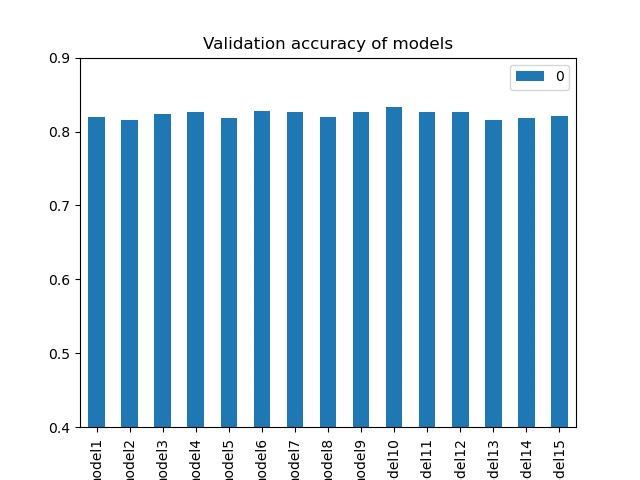 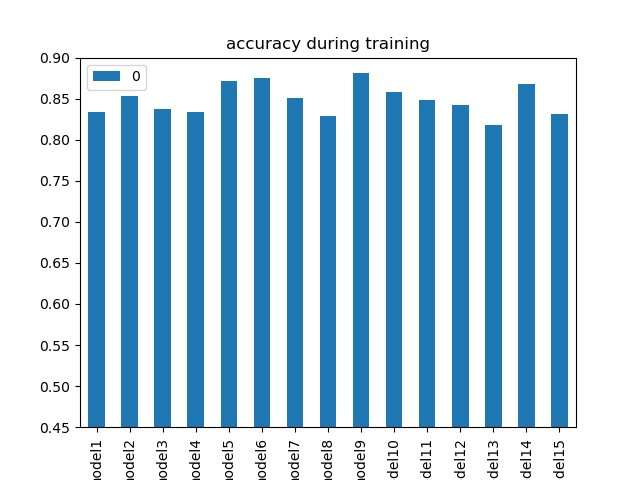







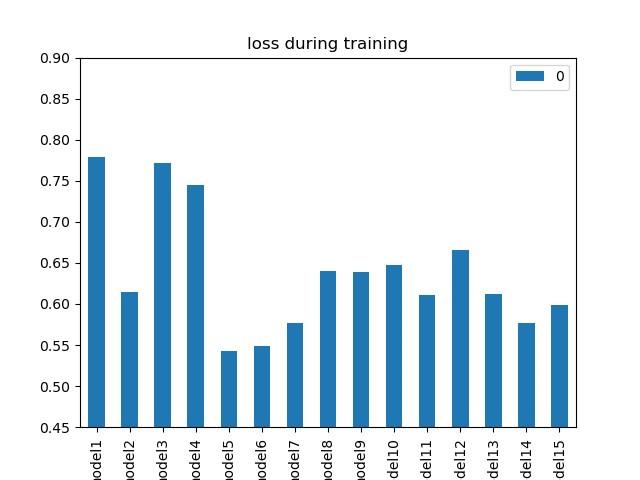 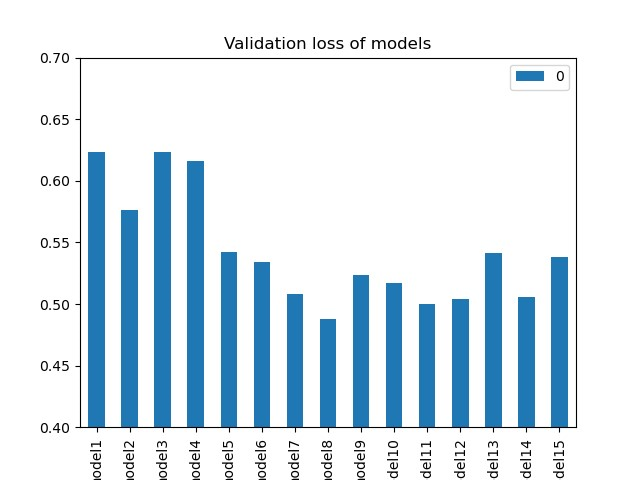

## What helped improve results the most in my opinion.Was reducting learning rates.

#### Reducing learning rates had the greatest effect. The accuracy increased but the stability of the validation results between training sessions did also, meaning
#### the models fit better to the validation data. And that might mean better results on the test data.
#### Please see the figure below. The green line is the overall accuracy for model 7, 
#### and it looks much smoother and less jagged than model 9. But model 9 shows better results for the validation accuracy. 


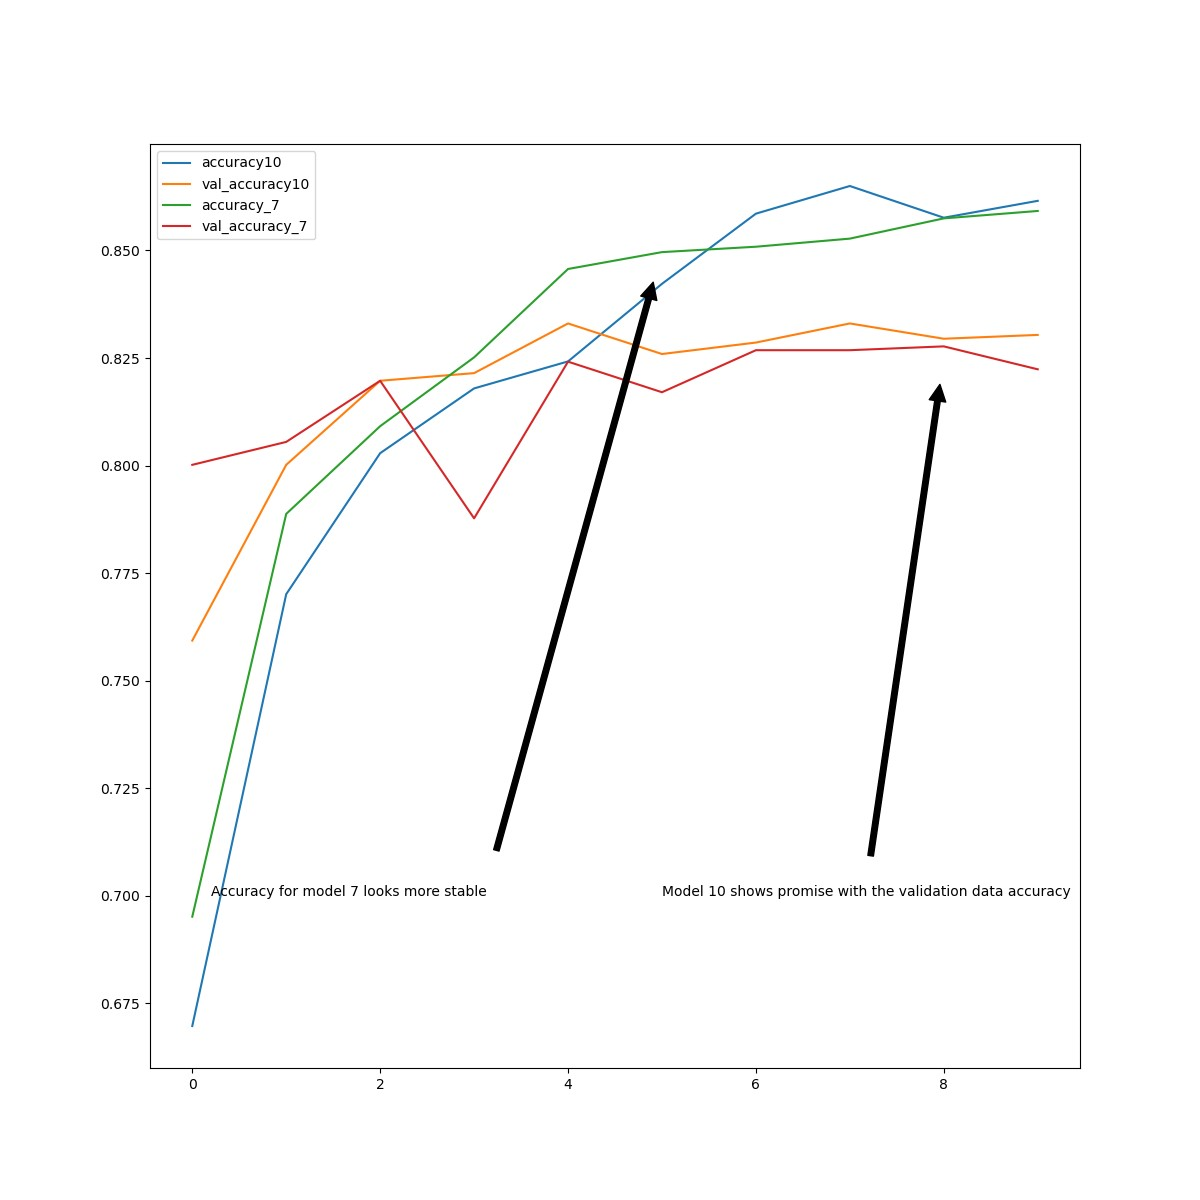



#### And looking at the confusion matrix model 7,

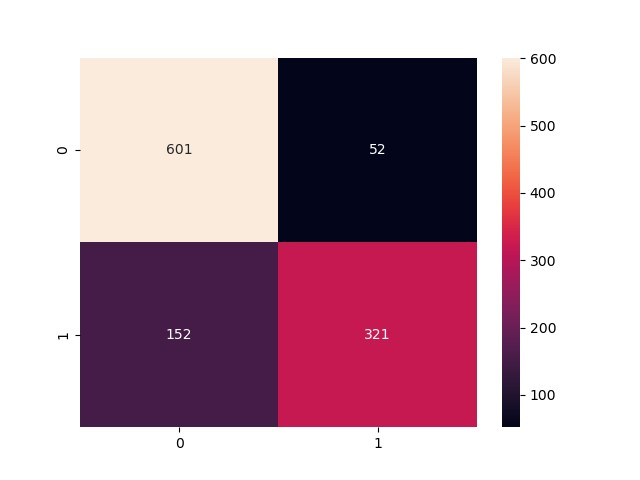

#### and the best performing model. There is little to no difference. 

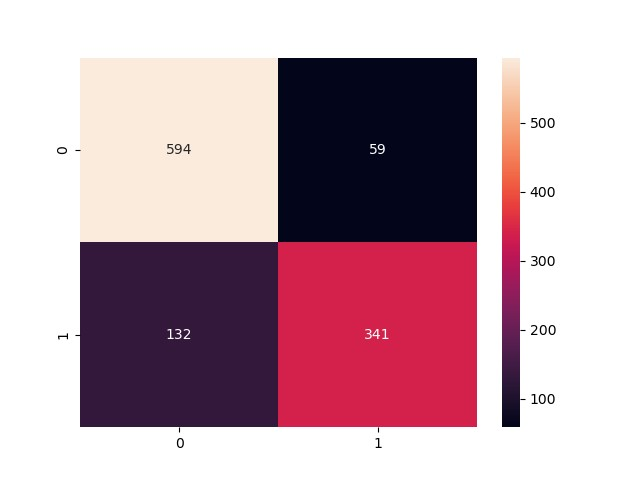]



### Worst Model: 16
#### I tried to apply a function that did not work at all (softmax).Somehow it caused the model
#### to put everything into two categories (Both were wrong) I am thinking 
#### I needed to apply some other transformations before I applied this
#### function or maybe apply it more than once. But either way it was not useful by any means.

Statistics for worst model
Loss: 0.42435210943222046
Accuracy: 0.4200710356235504

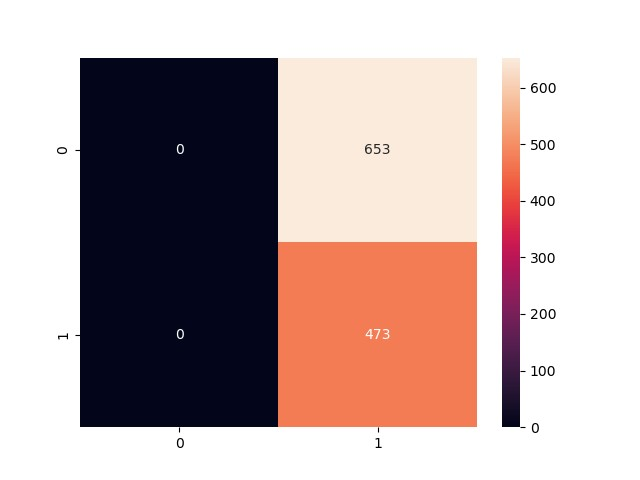   



#### Now for the best performing model. 
Statistics for best model
Loss: 0.39970090985298157
Accuracy: 0.8303729891777039


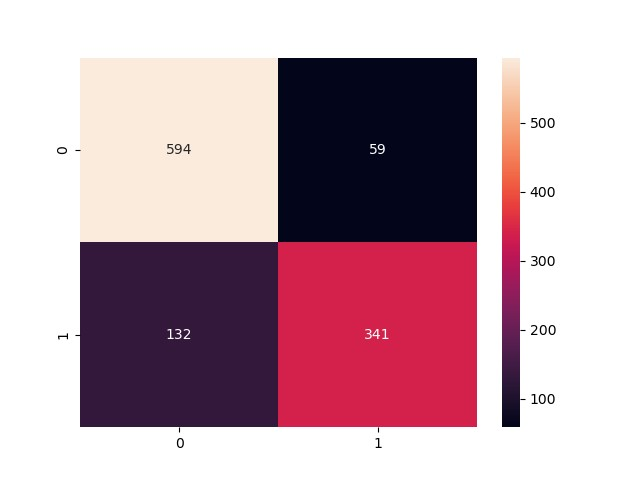] 


## In the future I would probably try to figure out how to clean the data better. Most submission scores were somewhat similiar to mine, meaning the data had a fair bit to do with how well the model fared. But no matter how well I cleaned the data it seemed to perform similiarly. Either way I am pretty happy with my results and my model performance. 
## My kaggle submissions
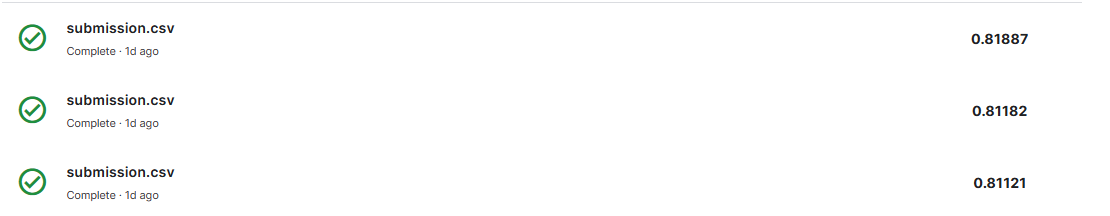

In [120]:
from keras import models, layers

In [27]:
model = Sequential()

model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
   
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 100)           1746500   
                                                                 
 bidirectional (Bidirectiona  (None, 31, 62)           32736     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 62)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 62)               248       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 62)                0         
                                                      

In [127]:
from keras_visualizer import visualizer

my_settings = {
    'MAX_NEURONS': 10,
    'INPUT_EMBEDDING_COLOR': 'orange',
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}

# model = ...

visualizer(model, file_format='png', settings=my_settings)

In [122]:
epoch = 10

I moved batch normalization up one stop (It is now second) 
Otherwise no change

In [29]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=1, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 5,min_lr = 0.0001)
model_history_1 = model.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.7787 - accuracy: 0.5986 - val_loss: 0.6234 - val_accuracy: 0.7673 - lr: 0.0010 - 17s/epoch - 87ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5738 - accuracy: 0.7198 - val_loss: 0.4721 - val_accuracy: 0.7948 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 3/10
200/200 - 10s - loss: 0.5254 - accuracy: 0.7668 - val_loss: 0.4459 - val_accuracy: 0.8099 - lr: 0.0010 - 10s/epoch - 51ms/step
Epoch 4/10
200/200 - 10s - loss: 0.4785 - accuracy: 0.7900 - val_loss: 0.4469 - val_accuracy: 0.8126 - lr: 0.0010 - 10s/epoch - 50ms/step
Epoch 5/10
200/200 - 10s - loss: 0.4577 - accuracy: 0.8120 - val_loss: 0.4421 - val_accuracy: 0.8188 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 6/10
200/200 - 10s - loss: 0.4313 - accuracy: 0.8223 - val_loss: 0.4081 - val_accuracy: 0.8197 - lr: 0.0010 - 10s/epoch - 50ms/step
Epoch 7/10
200/200 - 10s - loss: 0.4110 - accuracy: 0.8339 - val_loss: 0.4072 - val_accuracy: 0.8179 - lr: 0.0010 - 10s/epoch - 52ms/step
Epoch 8/10
200/200 - 10s - loss: 0

In [30]:
model1 = Sequential()
model1.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model1.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
model1.add(BatchNormalization())
model1.add(GlobalMaxPool1D())
model1.add(Dense(length_long_sentence, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(length_long_sentence, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation = 'sigmoid'))
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 100)           1746500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 31, 62)           32736     
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 31, 62)           248       
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 62)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 31)                1953      
                                                      

In [31]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=1, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 1,min_lr = 0.0001)
model_history_2 = model1.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.6148 - accuracy: 0.6698 - val_loss: 0.5763 - val_accuracy: 0.7806 - lr: 0.0010 - 17s/epoch - 86ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5031 - accuracy: 0.7769 - val_loss: 0.4620 - val_accuracy: 0.8037 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 3/10
200/200 - 10s - loss: 0.4539 - accuracy: 0.8093 - val_loss: 0.4173 - val_accuracy: 0.8099 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 10s - loss: 0.4252 - accuracy: 0.8264 - val_loss: 0.4181 - val_accuracy: 0.8046 - lr: 0.0010 - 10s/epoch - 52ms/step
Epoch 5/10
200/200 - 10s - loss: 0.3857 - accuracy: 0.8459 - val_loss: 0.4110 - val_accuracy: 0.8091 - lr: 2.0000e-04 - 10s/epoch - 48ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001.
200/200 - 10s - loss: 0.3738 - accuracy: 0.8529 - val_loss: 0.4132 - val_accuracy: 0.8126 - lr: 2.0000e-04 - 10s/epoch - 50ms/step
Epoch 7/10
200/200 - 10s

Nothing changed Going to move normalization

In [73]:
model2 = Sequential()
model2.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model2.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
model2.add(GlobalMaxPool1D())
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(length_long_sentence, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(length_long_sentence, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation = 'sigmoid'))
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [69]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=1, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 1,min_lr = 0.0001)
model_history_3 = model2.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.7719 - accuracy: 0.5898 - val_loss: 0.6232 - val_accuracy: 0.7469 - lr: 0.0010 - 17s/epoch - 84ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5895 - accuracy: 0.7066 - val_loss: 0.4905 - val_accuracy: 0.8091 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 3/10
200/200 - 9s - loss: 0.5138 - accuracy: 0.7631 - val_loss: 0.4450 - val_accuracy: 0.8028 - lr: 0.0010 - 9s/epoch - 47ms/step
Epoch 4/10
200/200 - 10s - loss: 0.4807 - accuracy: 0.7913 - val_loss: 0.4308 - val_accuracy: 0.8135 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 5/10
200/200 - 10s - loss: 0.4632 - accuracy: 0.8128 - val_loss: 0.4220 - val_accuracy: 0.8082 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 9s - loss: 0.4382 - accuracy: 0.8250 - val_loss: 0.4382 - val_accuracy: 0.8135 - lr: 0.0010 - 9s/epoch - 47ms/step
Epoch 7/10
200/200 - 10s - loss: 0.4085 - accuracy: 0.8379 - val_loss: 0.4170 - val_accuracy: 0.82

Changed nothing but made the learning rate much slower

In [74]:
model3 = Sequential()
model3.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model3.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
model3.add(GlobalMaxPool1D())
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(length_long_sentence, activation = "relu"))
model3.add(Dropout(0.5))
model3.add(Dense(length_long_sentence, activation = "relu"))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=1, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 1,min_lr = 0.0001)
model_history_4 = model3.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 16s - loss: 0.7447 - accuracy: 0.5990 - val_loss: 0.6158 - val_accuracy: 0.7673 - lr: 0.0010 - 16s/epoch - 82ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5655 - accuracy: 0.7223 - val_loss: 0.4704 - val_accuracy: 0.8037 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 3/10
200/200 - 10s - loss: 0.5104 - accuracy: 0.7734 - val_loss: 0.4338 - val_accuracy: 0.8153 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 4/10
200/200 - 9s - loss: 0.4743 - accuracy: 0.8026 - val_loss: 0.4195 - val_accuracy: 0.8064 - lr: 0.0010 - 9s/epoch - 47ms/step
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 10s - loss: 0.4462 - accuracy: 0.8142 - val_loss: 0.4360 - val_accuracy: 0.8215 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 6/10
200/200 - 9s - loss: 0.4223 - accuracy: 0.8339 - val_loss: 0.4136 - val_accuracy: 0.8215 - lr: 2.0000e-04 - 9s/epoch - 47ms/step
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001.
200/200 - 10s - loss:

Changed the Dropout Rate to 0.2 results = good

In [76]:
model4 = Sequential()
model4.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model4.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
model4.add(GlobalMaxPool1D())
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(length_long_sentence, activation = "relu"))
model4.add(Dropout(0.2))
model4.add(Dense(length_long_sentence, activation = "relu"))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation = 'sigmoid'))
model4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [77]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=1, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 1,min_lr = 0.0001)
model_history_5 = model4.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.5433 - accuracy: 0.7309 - val_loss: 0.5422 - val_accuracy: 0.7842 - lr: 0.0010 - 17s/epoch - 83ms/step
Epoch 2/10
200/200 - 9s - loss: 0.4561 - accuracy: 0.8029 - val_loss: 0.4396 - val_accuracy: 0.8108 - lr: 0.0010 - 9s/epoch - 47ms/step
Epoch 3/10
200/200 - 10s - loss: 0.4187 - accuracy: 0.8194 - val_loss: 0.4221 - val_accuracy: 0.8091 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 4/10
200/200 - 10s - loss: 0.3937 - accuracy: 0.8306 - val_loss: 0.4203 - val_accuracy: 0.8179 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 10s - loss: 0.3673 - accuracy: 0.8476 - val_loss: 0.4424 - val_accuracy: 0.8055 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001.
200/200 - 10s - loss: 0.3267 - accuracy: 0.8650 - val_loss: 0.4285 - val_accuracy: 0.8171 - lr: 2.0000e-04 - 10s/epoch - 48ms/step
Epoch 7/10
200/200 - 9s - loss

Changed the patience for the trainer to from 5 to 1. A reduction in val_accuracy drop over time. So a good change.

In [78]:
model5 = Sequential()
model5.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model5.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model5.add(GlobalMaxPool1D())
model5.add(BatchNormalization())
model5.add(Dropout(0.2))
model5.add(Dense(length_long_sentence, activation = "relu"))
model5.add(Dropout(0.2))
model5.add(Dense(length_long_sentence, activation = "relu"))
model5.add(Dropout(0.2))
model5.add(Dense(1, activation = 'sigmoid'))
model5.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 2, patience = 1,min_lr = 0.0001)
model_history_6 = model5.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 16s - loss: 0.5486 - accuracy: 0.7243 - val_loss: 0.5341 - val_accuracy: 0.7913 - lr: 0.0010 - 16s/epoch - 79ms/step
Epoch 2/10
200/200 - 10s - loss: 0.4565 - accuracy: 0.7982 - val_loss: 0.4260 - val_accuracy: 0.8171 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 3/10
200/200 - 9s - loss: 0.4191 - accuracy: 0.8208 - val_loss: 0.4259 - val_accuracy: 0.8126 - lr: 0.0010 - 9s/epoch - 47ms/step
Epoch 4/10
200/200 - 9s - loss: 0.3930 - accuracy: 0.8352 - val_loss: 0.4135 - val_accuracy: 0.8099 - lr: 0.0010 - 9s/epoch - 47ms/step
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 10s - loss: 0.3596 - accuracy: 0.8520 - val_loss: 0.4171 - val_accuracy: 0.8259 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 6/10
200/200 - 9s - loss: 0.3262 - accuracy: 0.8659 - val_loss: 0.4110 - val_accuracy: 0.8277 - lr: 2.0000e-04 - 9s/epoch - 47ms/step
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001.
200/200 - 9s - loss: 0.

Going to add Spatial Dropout - made loss worse but val accuracy better


In [80]:
model6 = Sequential()
model6.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model6.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model6.add(SpatialDropout1D(0.2))
model6.add(GlobalMaxPool1D())
model6.add(BatchNormalization())
model6.add(Dropout(0.2))
model6.add(Dense(length_long_sentence, activation = "relu"))
model6.add(Dropout(0.2))
model6.add(Dense(length_long_sentence, activation = "relu"))
model6.add(Dropout(0.2))
model6.add(Dense(1, activation = 'sigmoid'))
model6.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 2, patience = 1,min_lr = 0.0001)
model_history_7 = model6.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.5766 - accuracy: 0.6952 - val_loss: 0.5081 - val_accuracy: 0.8002 - lr: 0.0010 - 17s/epoch - 86ms/step
Epoch 2/10
200/200 - 10s - loss: 0.4787 - accuracy: 0.7888 - val_loss: 0.4496 - val_accuracy: 0.8055 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 3/10
200/200 - 10s - loss: 0.4413 - accuracy: 0.8092 - val_loss: 0.4105 - val_accuracy: 0.8197 - lr: 0.0010 - 10s/epoch - 52ms/step
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 10s - loss: 0.4123 - accuracy: 0.8252 - val_loss: 0.4811 - val_accuracy: 0.7877 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 5/10
200/200 - 10s - loss: 0.3777 - accuracy: 0.8457 - val_loss: 0.4060 - val_accuracy: 0.8242 - lr: 2.0000e-04 - 10s/epoch - 48ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001.
200/200 - 10s - loss: 0.3708 - accuracy: 0.8496 - val_loss: 0.4110 - val_accuracy: 0.8171 - lr: 2.0000e-04 - 10s/epoch - 50ms/step
Epoch 7/10
200/200 - 10s

Added two more sets of batch normalization

In [503]:
model7 = Sequential()
model7.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model7.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model7.add(SpatialDropout1D(0.2))
model7.add(GlobalMaxPool1D())
model7.add(BatchNormalization())
model7.add(Dropout(0.2))
model7.add(Dense(length_long_sentence, activation = "relu"))
model7.add(BatchNormalization())
model7.add(Dropout(0.2))
model7.add(Dense(length_long_sentence, activation = "relu"))
model7.add(BatchNormalization())
model7.add(Dropout(0.2))
model7.add(Dense(1, activation = 'sigmoid'))
model7.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [504]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 2, patience = 1,min_lr = 0.0001)
model_history_8 = model7.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 18s - loss: 0.6319 - accuracy: 0.6782 - val_loss: 0.5105 - val_accuracy: 0.7718 - lr: 0.0010 - 18s/epoch - 91ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5033 - accuracy: 0.7729 - val_loss: 0.4396 - val_accuracy: 0.8037 - lr: 0.0010 - 10s/epoch - 50ms/step
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 10s - loss: 0.4562 - accuracy: 0.8004 - val_loss: 0.4441 - val_accuracy: 0.8037 - lr: 0.0010 - 10s/epoch - 51ms/step
Epoch 4/10
200/200 - 11s - loss: 0.4291 - accuracy: 0.8131 - val_loss: 0.4186 - val_accuracy: 0.8117 - lr: 2.0000e-04 - 11s/epoch - 53ms/step
Epoch 5/10
200/200 - 10s - loss: 0.4103 - accuracy: 0.8280 - val_loss: 0.4136 - val_accuracy: 0.8126 - lr: 2.0000e-04 - 10s/epoch - 50ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001.
200/200 - 10s - loss: 0.4052 - accuracy: 0.8278 - val_loss: 0.4137 - val_accuracy: 0.8197 - lr: 2.0000e-04 - 10s/epoch - 51ms/step
Epoch 7/10
200/200 -

Changing the optimizer to Adam, Worse

In [88]:
model8 = Sequential()
model8.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model8.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model8.add(SpatialDropout1D(0.2))
model8.add(GlobalMaxPool1D())
model8.add(BatchNormalization())
model8.add(Dropout(0.2))
model8.add(Dense(length_long_sentence, activation = "relu"))
model8.add(BatchNormalization())
model8.add(Dropout(0.2))
model8.add(Dense(length_long_sentence, activation = "relu"))
model8.add(BatchNormalization())
model8.add(Dropout(0.2))
model8.add(Dense(1, activation = 'sigmoid'))
model8.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 2, patience = 1,min_lr = 0.0001)
model_history_9 = model8.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 20s - loss: 0.6385 - accuracy: 0.6763 - val_loss: 0.5237 - val_accuracy: 0.7931 - lr: 0.0010 - 20s/epoch - 98ms/step
Epoch 2/10
200/200 - 12s - loss: 0.5002 - accuracy: 0.7728 - val_loss: 0.4413 - val_accuracy: 0.7984 - lr: 0.0010 - 12s/epoch - 59ms/step
Epoch 3/10
200/200 - 12s - loss: 0.4462 - accuracy: 0.8056 - val_loss: 0.4191 - val_accuracy: 0.8171 - lr: 0.0010 - 12s/epoch - 62ms/step
Epoch 4/10
200/200 - 12s - loss: 0.4100 - accuracy: 0.8241 - val_loss: 0.4164 - val_accuracy: 0.8215 - lr: 0.0010 - 12s/epoch - 61ms/step
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 12s - loss: 0.3607 - accuracy: 0.8523 - val_loss: 0.4202 - val_accuracy: 0.8268 - lr: 0.0010 - 12s/epoch - 61ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001.
200/200 - 13s - loss: 0.3221 - accuracy: 0.8708 - val_loss: 0.4265 - val_accuracy: 0.8206 - lr: 2.0000e-04 - 13s/epoch - 64ms/step
Epoch 7/10
200/200 - 12s - l

Going to reduce min learning rate

In [92]:
model9 = Sequential()
model9.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model9.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model9.add(SpatialDropout1D(0.2))
model9.add(GlobalMaxPool1D())
model9.add(BatchNormalization())
model9.add(Dropout(0.2))
model9.add(Dense(length_long_sentence, activation = "relu"))
model9.add(BatchNormalization())
model9.add(Dropout(0.2))
model9.add(Dense(length_long_sentence, activation = "relu"))
model9.add(BatchNormalization())
model9.add(Dropout(0.2))
model9.add(Dense(1, activation = 'sigmoid'))
model9.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 2, patience = 1,min_lr = 0.00001)
model_history_10 = model9.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.6470 - accuracy: 0.6698 - val_loss: 0.5168 - val_accuracy: 0.7593 - lr: 0.0010 - 17s/epoch - 86ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5036 - accuracy: 0.7701 - val_loss: 0.4343 - val_accuracy: 0.8002 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 3/10
200/200 - 10s - loss: 0.4535 - accuracy: 0.8029 - val_loss: 0.4134 - val_accuracy: 0.8197 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 4/10
200/200 - 10s - loss: 0.4335 - accuracy: 0.8179 - val_loss: 0.4107 - val_accuracy: 0.8215 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 5/10
200/200 - 10s - loss: 0.4125 - accuracy: 0.8242 - val_loss: 0.3968 - val_accuracy: 0.8330 - lr: 0.0010 - 10s/epoch - 51ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
200/200 - 10s - loss: 0.3867 - accuracy: 0.8422 - val_loss: 0.3996 - val_accuracy: 0.8259 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
200/2

reducing the factor by which the training speed reduces. Increasing it first. Much worse.

In [94]:
model10 = Sequential()
model10.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model10.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model10.add(SpatialDropout1D(0.2))
model10.add(GlobalMaxPool1D())
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(length_long_sentence, activation = "relu"))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(length_long_sentence, activation = "relu"))
model10.add(BatchNormalization())
model10.add(Dropout(0.2))
model10.add(Dense(1, activation = 'sigmoid'))
model10.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [95]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, verbose = 2, patience = 1,min_lr = 0.00001)
model_history_11 = model10.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.6108 - accuracy: 0.6988 - val_loss: 0.5003 - val_accuracy: 0.7940 - lr: 0.0010 - 17s/epoch - 85ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5055 - accuracy: 0.7717 - val_loss: 0.4270 - val_accuracy: 0.8135 - lr: 0.0010 - 10s/epoch - 50ms/step
Epoch 3/10
200/200 - 10s - loss: 0.4532 - accuracy: 0.8004 - val_loss: 0.4166 - val_accuracy: 0.8206 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 4/10
200/200 - 10s - loss: 0.4272 - accuracy: 0.8129 - val_loss: 0.4108 - val_accuracy: 0.8179 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 - 10s - loss: 0.4067 - accuracy: 0.8332 - val_loss: 0.4189 - val_accuracy: 0.8126 - lr: 0.0010 - 10s/epoch - 50ms/step
Epoch 6/10
200/200 - 10s - loss: 0.3841 - accuracy: 0.8435 - val_loss: 0.4070 - val_accuracy: 0.8259 - lr: 5.0000e-04 - 10s/epoch - 48ms/step
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
200

Going to decrease the learning  rate factor  to 0.01

In [96]:
model11 = Sequential()
model11.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model11.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model11.add(SpatialDropout1D(0.2))
model11.add(GlobalMaxPool1D())
model11.add(BatchNormalization())
model11.add(Dropout(0.2))
model11.add(Dense(length_long_sentence, activation = "relu"))
model11.add(BatchNormalization())
model11.add(Dropout(0.2))
model11.add(Dense(length_long_sentence, activation = "relu"))
model11.add(BatchNormalization())
model11.add(Dropout(0.2))
model11.add(Dense(1, activation = 'sigmoid'))
model11.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [97]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.01, verbose = 2, patience = 1,min_lr = 0.00001)
model_history_12 = model11.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 19s - loss: 0.6663 - accuracy: 0.6649 - val_loss: 0.5038 - val_accuracy: 0.7647 - lr: 0.0010 - 19s/epoch - 94ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5178 - accuracy: 0.7671 - val_loss: 0.4218 - val_accuracy: 0.8099 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 3/10
200/200 - 10s - loss: 0.4668 - accuracy: 0.7947 - val_loss: 0.4185 - val_accuracy: 0.8144 - lr: 0.0010 - 10s/epoch - 51ms/step
Epoch 4/10
200/200 - 10s - loss: 0.4433 - accuracy: 0.8088 - val_loss: 0.4066 - val_accuracy: 0.8135 - lr: 0.0010 - 10s/epoch - 51ms/step
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
200/200 - 10s - loss: 0.4190 - accuracy: 0.8244 - val_loss: 0.4129 - val_accuracy: 0.8206 - lr: 0.0010 - 10s/epoch - 50ms/step
Epoch 6/10
200/200 - 10s - loss: 0.3965 - accuracy: 0.8377 - val_loss: 0.4020 - val_accuracy: 0.8259 - lr: 1.0000e-05 - 10s/epoch - 48ms/step
Epoch 7/10
200/200 - 10s - loss: 0.3868 - accuracy: 0.8424 - val_loss: 0.4007 - val_accura

Going to reduce the rate to 0.001. Model did not improve. 

In [98]:
model12 = Sequential()
model12.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model12.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model12.add(SpatialDropout1D(0.2))
model12.add(GlobalMaxPool1D())
model12.add(BatchNormalization())
model12.add(Dropout(0.2))
model12.add(Dense(length_long_sentence, activation = "relu"))
model12.add(BatchNormalization())
model12.add(Dropout(0.2))
model12.add(Dense(length_long_sentence, activation = "relu"))
model12.add(BatchNormalization())
model12.add(Dropout(0.2))
model12.add(Dense(1, activation = 'sigmoid'))
model12.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [99]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.001, verbose = 2, patience = 1,min_lr = 0.00001)
model_history_13 = model12.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.6123 - accuracy: 0.6881 - val_loss: 0.5414 - val_accuracy: 0.7469 - lr: 0.0010 - 17s/epoch - 86ms/step
Epoch 2/10
200/200 - 10s - loss: 0.5054 - accuracy: 0.7656 - val_loss: 0.4217 - val_accuracy: 0.7993 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-05.
200/200 - 10s - loss: 0.4618 - accuracy: 0.7902 - val_loss: 0.4292 - val_accuracy: 0.8064 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 4/10
200/200 - 9s - loss: 0.4338 - accuracy: 0.8087 - val_loss: 0.4181 - val_accuracy: 0.8162 - lr: 1.0000e-05 - 9s/epoch - 47ms/step
Epoch 5/10
200/200 - 10s - loss: 0.4323 - accuracy: 0.8093 - val_loss: 0.4167 - val_accuracy: 0.8135 - lr: 1.0000e-05 - 10s/epoch - 48ms/step
Epoch 6/10
200/200 - 10s - loss: 0.4280 - accuracy: 0.8150 - val_loss: 0.4163 - val_accuracy: 0.8126 - lr: 1.0000e-05 - 10s/epoch - 49ms/step
Epoch 7/10
200/200 - 10s - loss: 0.4272 - accuracy: 0.8183 - val_loss: 0.4156 - val_accuracy: 0.8153 

Changed Learning Rate back to 0.01 and changing dropout to 0.1

In [103]:
model13 = Sequential()
model13.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model13.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model13.add(SpatialDropout1D(0.1))
model13.add(GlobalMaxPool1D())
model13.add(BatchNormalization())
model13.add(Dropout(0.1))
model13.add(Dense(length_long_sentence, activation = "relu"))
model13.add(BatchNormalization())
model13.add(Dropout(0.1))
model13.add(Dense(length_long_sentence, activation = "relu"))
model13.add(BatchNormalization())
model13.add(Dropout(0.1))
model13.add(Dense(1, activation = 'sigmoid'))
model13.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='accuracy', patience=2, verbose=2, start_from_epoch = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.01, verbose = 2, patience = 1,min_lr = 0.00001)
model_history_14 = model13.fit(X_train, y_train, epochs =epoch,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/10
200/200 - 17s - loss: 0.5771 - accuracy: 0.7143 - val_loss: 0.5061 - val_accuracy: 0.7842 - lr: 0.0010 - 17s/epoch - 84ms/step
Epoch 2/10
200/200 - 10s - loss: 0.4675 - accuracy: 0.7894 - val_loss: 0.4311 - val_accuracy: 0.8028 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 3/10
200/200 - 10s - loss: 0.4276 - accuracy: 0.8195 - val_loss: 0.4240 - val_accuracy: 0.8126 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 4/10
200/200 - 10s - loss: 0.3988 - accuracy: 0.8325 - val_loss: 0.4185 - val_accuracy: 0.8179 - lr: 0.0010 - 10s/epoch - 48ms/step
Epoch 5/10
200/200 - 10s - loss: 0.3797 - accuracy: 0.8421 - val_loss: 0.4148 - val_accuracy: 0.8117 - lr: 0.0010 - 10s/epoch - 52ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
200/200 - 10s - loss: 0.3522 - accuracy: 0.8557 - val_loss: 0.4246 - val_accuracy: 0.8135 - lr: 0.0010 - 10s/epoch - 49ms/step
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-05.
200/200 - 10s - loss: 

# Changed monitoring for early stopper and learning rate adjuster to val_accuracy

In [108]:
model14 = Sequential()
model14.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model14.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model14.add(SpatialDropout1D(0.1))
model14.add(GlobalMaxPool1D())
model14.add(BatchNormalization())
model14.add(Dropout(0.1))
model14.add(Dense(length_long_sentence, activation = "relu"))
model14.add(BatchNormalization())
model14.add(Dropout(0.1))
model14.add(Dense(length_long_sentence, activation = "relu"))
model14.add(BatchNormalization())
model14.add(Dropout(0.1))
model14.add(Dense(1, activation = 'sigmoid'))
model14.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_accuracy', patience=2, verbose=2, start_from_epoch = 1, mode ="max")
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.01, verbose = 2, patience = 1,min_lr = 0.00001)
model_history_15 = model14.fit(X_train, y_train, epochs =20,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/20
200/200 - 17s - loss: 0.5989 - accuracy: 0.6997 - val_loss: 0.5382 - val_accuracy: 0.7957 - lr: 0.0010 - 17s/epoch - 84ms/step
Epoch 2/20
200/200 - 10s - loss: 0.4858 - accuracy: 0.7822 - val_loss: 0.4232 - val_accuracy: 0.8171 - lr: 0.0010 - 10s/epoch - 50ms/step
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
200/200 - 9s - loss: 0.4373 - accuracy: 0.8134 - val_loss: 0.4308 - val_accuracy: 0.8020 - lr: 0.0010 - 9s/epoch - 47ms/step
Epoch 4/20
200/200 - 10s - loss: 0.4185 - accuracy: 0.8223 - val_loss: 0.4180 - val_accuracy: 0.8197 - lr: 1.0000e-05 - 10s/epoch - 48ms/step
Epoch 5/20
200/200 - 10s - loss: 0.4063 - accuracy: 0.8308 - val_loss: 0.4150 - val_accuracy: 0.8206 - lr: 1.0000e-05 - 10s/epoch - 49ms/step
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-05.
200/200 - 10s - loss: 0.4124 - accuracy: 0.8209 - val_loss: 0.4134 - val_accuracy: 0.8197 - lr: 1.0000e-05 - 10s/epoch - 48ms/step
Epoch 7/20
200/200 - 10

Tried to change dense layer with softmax

In [123]:
model15 = Sequential()
model15.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model15.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.1)))
model15.add(SpatialDropout1D(0.1))
model15.add(GlobalMaxPool1D())
model15.add(BatchNormalization())
model15.add(Dropout(0.1))
model15.add(Dense(length_long_sentence, activation = "relu"))
model15.add(BatchNormalization())
model15.add(Dropout(0.1))
model15.add(Dense(length_long_sentence, activation = "relu"))
model15.add(BatchNormalization())
model15.add(Dropout(0.1))
model15.add(Dense(1, activation = 'softmax'))
model15.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [124]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_accuracy', patience=2, verbose=2, start_from_epoch = 1, mode ="max")
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.01, verbose = 2, patience = 1,min_lr = 0.00001)
model_history_16 = model15.fit(X_train, y_train, epochs =20,batch_size = 32,
    validation_data = [X_test, y_test],verbose = 2,
    callbacks = [reduce_lr,earlystopper])

Epoch 1/20
200/200 - 18s - loss: 0.5906 - accuracy: 0.4273 - val_loss: 0.5285 - val_accuracy: 0.4201 - lr: 0.0010 - 18s/epoch - 88ms/step
Epoch 2/20

Epoch 2: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
200/200 - 10s - loss: 0.4738 - accuracy: 0.4273 - val_loss: 0.4339 - val_accuracy: 0.4201 - lr: 0.0010 - 10s/epoch - 52ms/step
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-05.
200/200 - 10s - loss: 0.4305 - accuracy: 0.4273 - val_loss: 0.4241 - val_accuracy: 0.4201 - lr: 1.0000e-05 - 10s/epoch - 50ms/step
Epoch 4/20
200/200 - 10s - loss: 0.4392 - accuracy: 0.4273 - val_loss: 0.4244 - val_accuracy: 0.4201 - lr: 1.0000e-05 - 10s/epoch - 50ms/step
Epoch 4: early stopping


In [115]:
from sklearn.metrics import confusion_matrix

In [502]:
loss, accuracy = model.evaluate(X_test, y_test)


36/36 [==============================] - 0s 10ms/step - loss: 0.4698 - accuracy: 0.8162


In [130]:
y_pred = model.predict(X_test)
y_pres=np.round(y_pred).astype(int).reshape(1126)
ab=(confusion_matrix(y_test, y_pres))
ab

36/36 [==============================] - 0s 9ms/step


Loss: 0.46978893876075745
Accuracy: 0.8161634206771851


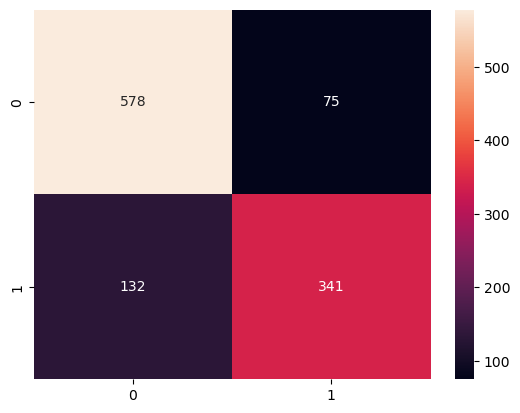

In [152]:
model0 = sns.heatmap(confusion_matrix(y_test, y_pres), annot =True, fmt='g')
print('Loss:', loss)
print('Accuracy:', accuracy)


In [351]:
loss, accuracy = model9.evaluate(X_test, y_test)


36/36 [==============================] - 0s 10ms/step - loss: 0.3997 - accuracy: 0.8304


In [352]:
y_pred = model9.predict(X_test)
y_pres=np.round(y_pred).astype(int).reshape(1126)
ab=(confusion_matrix(y_test, y_pres))
ab

36/36 [==============================] - 0s 9ms/step


array([[594,  59],
       [132, 341]])

Loss: 0.39970090985298157
Accuracy: 0.8303729891777039


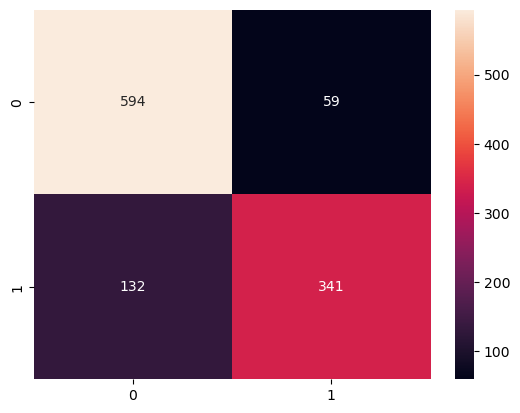

In [353]:
model_l0_not1 = sns.heatmap(confusion_matrix(y_test, y_pres), annot =True, fmt='g')
print('Loss:', loss)
print('Accuracy:', accuracy)
model_l0_not1.figure.savefig("Best_model.png")

In [505]:
loss, accuracy = model7.evaluate(X_test, y_test)

36/36 [==============================] - 0s 10ms/step - loss: 0.4152 - accuracy: 0.8188


36/36 [==============================] - 1s 9ms/step
Loss: 0.4151947498321533
Accuracy: 0.8188276886940002


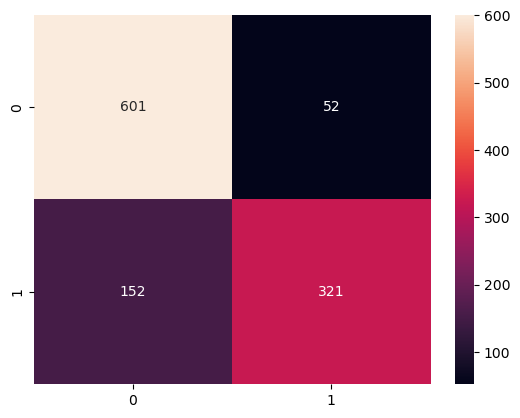

In [506]:
y_pred = model7.predict(X_test)
y_pres=np.round(y_pred).astype(int).reshape(1126)
ab=(confusion_matrix(y_test, y_pres))
ab
model7 = sns.heatmap(confusion_matrix(y_test, y_pres), annot =True, fmt='g')
print('Loss:', loss)
print('Accuracy:', accuracy)
model7.figure.savefig("Model7.png")

In [428]:
model10_hist = pd.DataFrame(model_history_10.history)
model7_hist = pd.DataFrame(model_history_7.history)

In [434]:
model10_hist =model10_hist[['accuracy','val_accuracy']]
model7_hist =model7_hist[['accuracy','val_accuracy']]

In [435]:
model10_hist

,accuracy,val_accuracy
0,0.669751,0.759325
1,0.770111,0.800178
2,0.802885,0.819716
3,0.817939,0.821492
4,0.824212,0.833037
5,0.842246,0.825933
6,0.858554,0.828597
7,0.864984,0.833037
8,0.857613,0.829485
9,0.861534,0.830373


In [436]:
model7_hist

,accuracy,val_accuracy
0,0.695154,0.800178
1,0.788772,0.805506
2,0.809158,0.819716
3,0.825153,0.787744
4,0.845695,0.824156
5,0.849616,0.817052
6,0.850870,0.826821
7,0.852752,0.826821
8,0.857457,0.827709
9,0.859181,0.822380


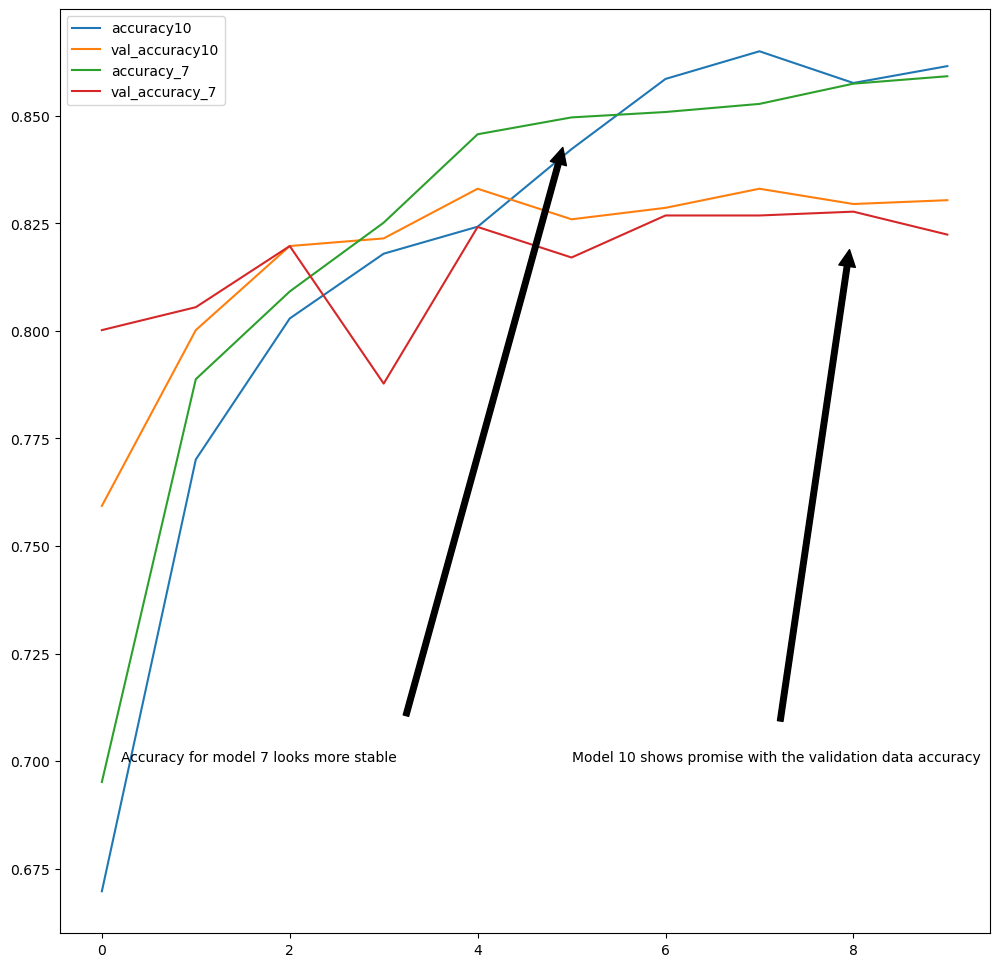

In [498]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(model10_hist)

ax.plot(model6_hist)
ax.legend(["accuracy10","val_accuracy10",'accuracy_7','val_accuracy_7'],loc ='best')


ax.annotate('Accuracy for model 7 looks more stable', xy=(5, 0.85), xytext=(0.2, 0.7),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Model 10 shows promise with the validation data accuracy', xy=(8, 0.825), xytext=(5, 0.7),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()
fig.figure.savefig("Plot Comparisons")

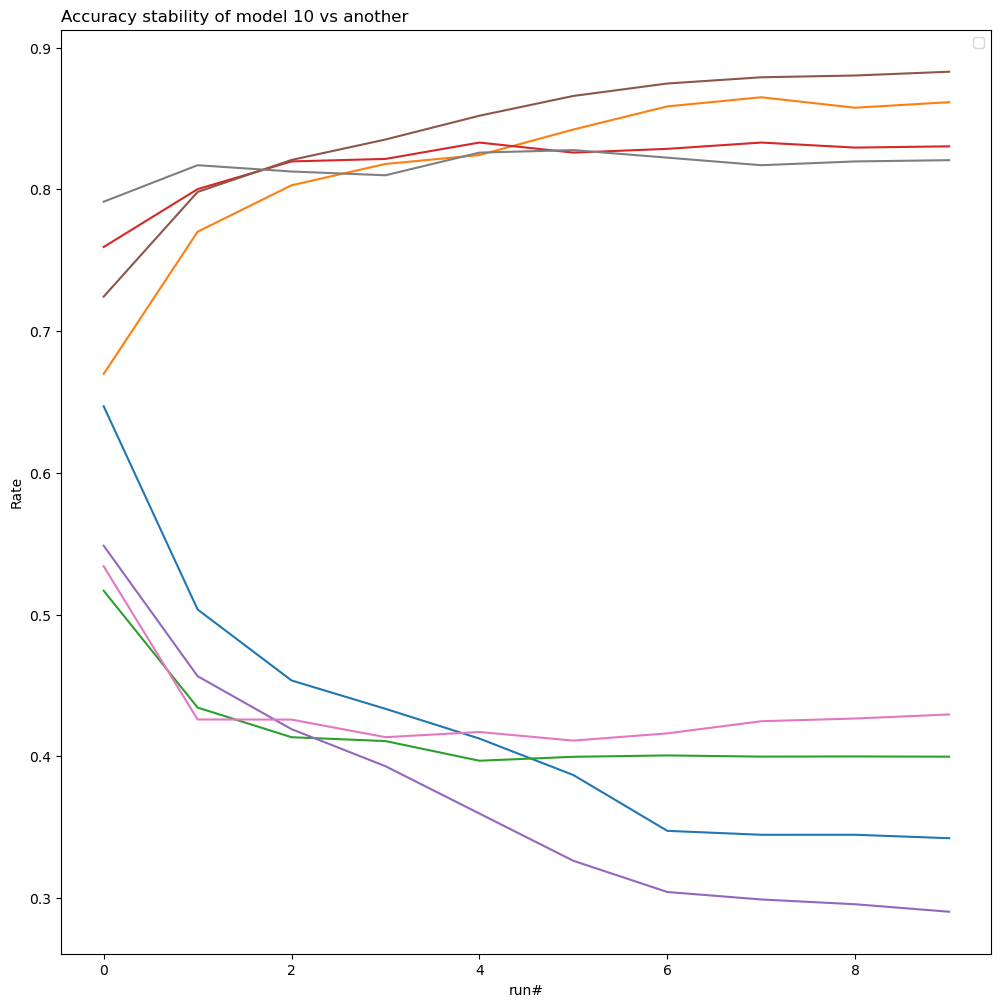

In [420]:

plt.figure(figsize=(12,12))
plt.plot(model10_hist)
plt.legend(loc='best')
plt.plot(model6_hist)
plt.legend(loc='best')
plt.legend()
plt.title("Accuracy stability of model 10 vs another", loc = 'left')
plt.xlabel("run#")
plt.ylabel("Rate")
plt.annotate('Local Max', xy =(5, 1),
                xytext =(5,1), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)
plt.show()

In [345]:
loss, accuracy = model15.evaluate(X_test, y_test)

36/36 [==============================] - 0s 9ms/step - loss: 0.4244 - accuracy: 0.4201


In [346]:
y_pred = model15.predict(X_test)
y_pres=np.round(y_pred).astype(int).reshape(1126)
ab=(confusion_matrix(y_test, y_pres))
ab

36/36 [==============================] - 1s 9ms/step


array([[  0, 653],
       [  0, 473]])

Loss: 0.42435210943222046
Accuracy: 0.4200710356235504


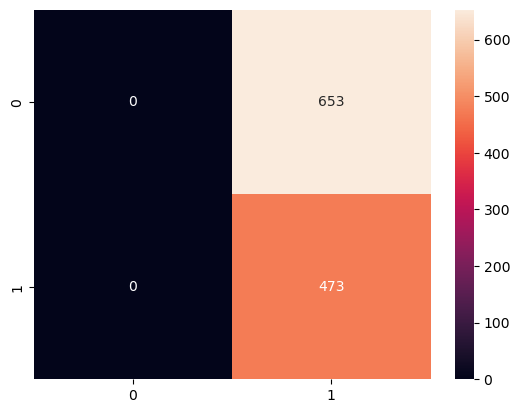

In [349]:
model_16 = sns.heatmap(confusion_matrix(y_test, y_pres), annot =True, fmt='g')
print('Loss:', loss)
print('Accuracy:', accuracy)
model_16.figure.savefig("worst_model.png")

In [171]:
model_history_1.history
epochs1=[0,1,2,3,4,5,6,7,8,9,10]

In [212]:
len(model_history_2.history)

5

In [310]:
Name = ['model1', 'model2', 'model3', 'model4','model5','model6','model7','model8','model9','model10','model11','model12','model13','model14','model15']
Dataframe2 = pd.DataFrame(zip(model_history_1.history['loss'],model_history_2.history['loss'],model_history_3.history['loss'],
                             model_history_4.history['loss'],model_history_5.history['loss'],model_history_6.history['loss'],model_history_7.history['loss'],
                             model_history_8.history['loss'],model_history_9.history['loss'],model_history_10.history['loss'],model_history_11.history['loss'],
                             model_history_12.history['loss'],model_history_13.history['loss'],model_history_14.history['loss'],model_history_15.history['loss']
                              ),columns=Name)


In [228]:
Name = ['model1', 'model2', 'model3', 'model4','model5','model6','model7','model8','model9','model10','model11','model12','model13','model14','model15']
Dataframe3 = pd.DataFrame(zip(model_history_1.history['accuracy'],model_history_2.history['accuracy'],model_history_3.history['accuracy'],
                             model_history_4.history['accuracy'],model_history_5.history['accuracy'],model_history_6.history['accuracy'],model_history_7.history['accuracy'],
                             model_history_8.history['accuracy'],model_history_9.history['accuracy'],model_history_10.history['accuracy'],model_history_11.history['accuracy'],
                             model_history_12.history['accuracy'],model_history_13.history['accuracy'],model_history_14.history['accuracy'],model_history_15.history['accuracy']
                              ),columns=Name)
Dataframe3


,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15
0,0.598557,0.669751,0.589776,0.599028,0.730908,0.724322,0.695154,0.671476,0.676337,0.669751,0.698761,0.664889,0.688098,0.714286,0.699702
1,0.719774,0.776854,0.706602,0.722283,0.802885,0.798181,0.788772,0.782500,0.772777,0.770111,0.771679,0.767132,0.765564,0.789399,0.782186
2,0.766818,0.809315,0.763055,0.773404,0.819351,0.820762,0.809158,0.801004,0.805551,0.802885,0.800376,0.794731,0.790183,0.819508,0.813392
3,0.790027,0.826407,0.791281,0.802572,0.830641,0.835189,0.825153,0.819508,0.824055,0.817939,0.812921,0.808844,0.808687,0.832523,0.822330
4,0.811981,0.845852,0.812765,0.814176,0.847577,0.851968,0.845695,0.823742,0.852282,0.824212,0.833150,0.824369,0.809315,0.842089,0.830798
5,0.822330,0.852909,0.824996,0.833934,0.864984,0.865924,0.849616,0.827662,0.870786,0.842246,0.843500,0.837698,0.814960,0.855732,0.820919
6,0.833934,0.853536,0.837855,0.834248,0.871413,0.874706,0.850870,0.828760,0.880665,0.858554,0.848204,0.842402,0.818253,0.867963,0.828916


In [533]:
Name = ['model1', 'model2', 'model3', 'model4','model5','model6','model7','model8','model9','model10','model11','model12','model13','model14','model15']
Dataframe4 = pd.DataFrame(zip(model_history_1.history['val_accuracy'],model_history_2.history['val_accuracy'],model_history_3.history['val_accuracy'],
                             model_history_4.history['val_accuracy'],model_history_5.history['val_accuracy'],model_history_6.history['val_accuracy'],model_history_7.history['val_accuracy'],
                             model_history_8.history['val_accuracy'],model_history_9.history['val_accuracy'],model_history_10.history['val_accuracy'],model_history_11.history['val_accuracy'],
                             model_history_12.history['val_accuracy'],model_history_13.history['val_accuracy'],model_history_14.history['val_accuracy'],model_history_15.history['val_accuracy']
                            ),columns=Name)
Dataframe4


,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15
0,0.767318,0.780639,0.746892,0.767318,0.784192,0.791297,0.800178,0.771758,0.793073,0.759325,0.793961,0.764654,0.746892,0.784192,0.795737
1,0.794849,0.803730,0.809059,0.803730,0.810835,0.817052,0.805506,0.803730,0.798401,0.800178,0.813499,0.809947,0.799290,0.802842,0.817052
2,0.809947,0.809947,0.802842,0.815275,0.809059,0.812611,0.819716,0.803730,0.817052,0.819716,0.820604,0.814387,0.806394,0.812611,0.801954
3,0.812611,0.804618,0.813499,0.806394,0.817940,0.809947,0.787744,0.811723,0.821492,0.821492,0.817940,0.813499,0.816163,0.817940,0.819716
4,0.818828,0.809059,0.808170,0.821492,0.805506,0.825933,0.824156,0.812611,0.826821,0.833037,0.812611,0.820604,0.813499,0.811723,0.820604
5,0.819716,0.812611,0.813499,0.821492,0.817052,0.827709,0.817052,0.819716,0.820604,0.825933,0.825933,0.825933,0.812611,0.813499,0.819716
6,0.817940,0.815275,0.823268,0.825933,0.817940,0.822380,0.826821,0.817940,0.820604,0.828597,0.819716,0.824156,0.815275,0.817940,0.817940


In [534]:
accuracy5 = pd.DataFrame(Dataframe4.max())

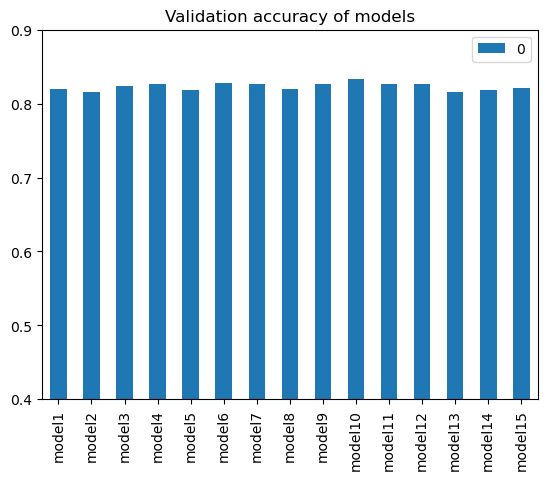

In [536]:
figure7 = accuracy5.plot(kind='bar',)
plt.ylim(0.4,0.90)
plt.title("Validation accuracy of models")

figure7.figure.savefig("Overall_accuracy")


In [230]:
Name = ['model1', 'model2', 'model3', 'model4','model5','model6','model7','model8','model9','model10','model11','model12','model13','model14','model15']
Dataframe5 = pd.DataFrame(zip(model_history_1.history['val_loss'],model_history_2.history['val_loss'],model_history_3.history['val_loss'],
                             model_history_4.history['val_loss'],model_history_5.history['val_loss'],model_history_6.history['val_loss'],model_history_7.history['val_loss'],
                             model_history_8.history['val_loss'],model_history_9.history['val_loss'],model_history_10.history['val_loss'],model_history_11.history['val_loss'],
                             model_history_12.history['val_loss'],model_history_13.history['val_loss'],model_history_14.history['val_loss'],model_history_15.history['val_loss']
                              ),columns=Name)
Dataframe5


,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15
0,0.623391,0.576336,0.623230,0.615820,0.542184,0.534068,0.508115,0.487966,0.523663,0.516786,0.500259,0.503812,0.541390,0.506070,0.538244
1,0.472104,0.461991,0.490547,0.470389,0.439576,0.425959,0.449630,0.435874,0.441314,0.434343,0.427003,0.421783,0.421701,0.431068,0.423235
2,0.445906,0.417254,0.445050,0.433821,0.422135,0.425858,0.410535,0.442956,0.419114,0.413418,0.416568,0.418482,0.429240,0.423992,0.430755
3,0.446924,0.418062,0.430764,0.419468,0.420345,0.413451,0.481060,0.416068,0.416444,0.410711,0.410759,0.406649,0.418145,0.418526,0.417970
4,0.442073,0.410973,0.422018,0.435967,0.442362,0.417111,0.406001,0.417871,0.420207,0.396833,0.418910,0.412893,0.416733,0.414773,0.414984
5,0.408069,0.413175,0.438244,0.413603,0.428519,0.411037,0.411008,0.414480,0.426518,0.399609,0.406979,0.401953,0.416315,0.424567,0.413398
6,0.407185,0.412298,0.417026,0.415588,0.433790,0.416139,0.402418,0.413664,0.427012,0.400583,0.416575,0.400660,0.415594,0.419803,0.413179


In [516]:
accuracy7 = pd.DataFrame(Dataframe5.max())

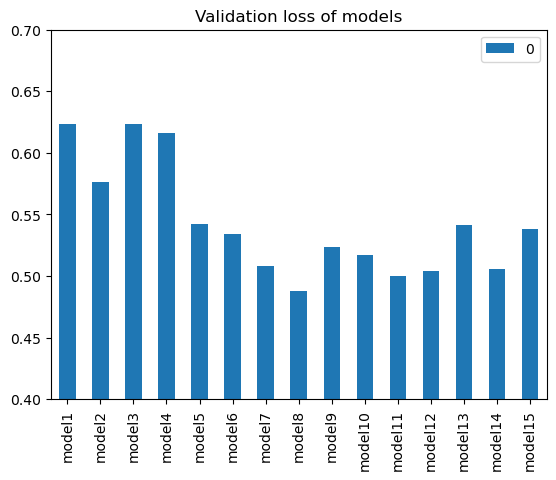

In [531]:
figure8 = accuracy7.plot(kind='bar',)
plt.ylim(0.4,0.7)
plt.title("Validation loss of models")

figure8.figure.savefig("Overall_loss_val")

In [529]:
accuracy10 = pd.DataFrame(Dataframe2.max())

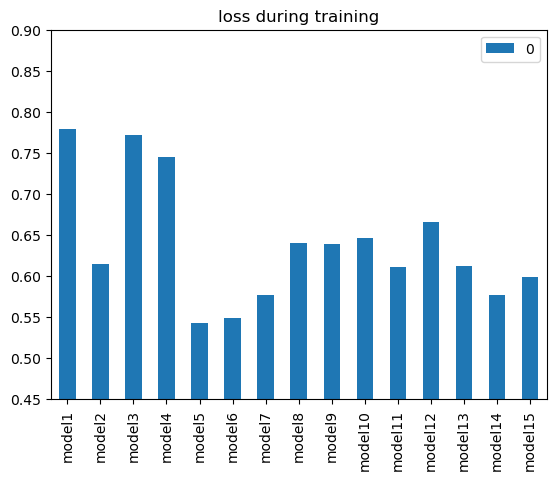

In [530]:
figure101 = accuracy10.plot(kind='bar',)
plt.ylim(0.45,0.9)
plt.title("loss during training")

figure101.figure.savefig("Overall_loss_training1")

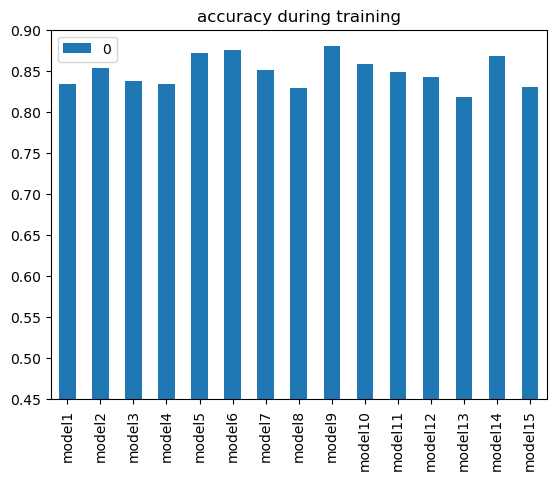

In [532]:
accuracy12 = pd.DataFrame(Dataframe3.max())
figure105 = accuracy12.plot(kind='bar',)
plt.ylim(0.45,0.9)
plt.title("accuracy during training")

figure105.figure.savefig("Overall_accuracy_training")

In [311]:
import plotly.graph_objects as go

import pandas as pd
values1 = [0,1,2,3,4,5,6]


# Initialize figure
fig = go.Figure()

# Add Traces

fig.add_trace(
    go.Scatter(y=Dataframe2.model1,
               x=values1,
               name="Model0_model_loss",
               line=dict(color="#33CFA5")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model2,
               x=values1,
               name="Model1_model_loss",
               line=dict(color="#1f77b4")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model3,
               x=values1,
               name="Model2_model_loss",
               visible=False,
               line=dict(color="#ff7f0e")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model4,
               x=values1,
               name="Model3_model_loss",
               visible=False,
               line=dict(color="#2ca02c")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model5,
               x=values1,
               name="Model4_model_loss",
               line=dict(color="#d62728")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model6,
               x=values1,
               name="Model5_model_loss",
               line=dict(color="#9467bd")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model7,
               x=values1,
               name="Model6_model_loss",
               visible=False,
               line=dict(color="#8c564b")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model8,
               x=values1,
               x
               name="Model7_model_loss",
               visible=False,
               line=dict(color="#e377c2")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model9,
               x=values1,
               name="Model8_model_loss",
               line=dict(color="#7f7f7f")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model10,
               x=values1,
               name="Model9_model_loss",
               visible=False,
               line=dict(color="#bcbd22")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model11,
               x=values1,
               name="Model10_model_loss",
               visible=False,
               line=dict(color="#17becf")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model12,
               x=values1,
               name="Model11_model_loss",
               line=dict(color="#8c564b")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model13,
               x=values1,
               name="Model12_model_loss",
               visible=False,
               line=dict(color="#d62728")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model14,
               x=values1,
               name="Model13_model_loss",
               visible=False,
               line=dict(color="#9467bd")))
fig.add_trace(
    go.Scatter(y=Dataframe2.model15,
               x=values1,
               name="Model14_model_loss",
               visible=False,
               line=dict(color="#9467bd")))





button_layer_1_height = 1.08
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                     label="Loss",
                     method="update",
                     args=[{"visible": [True, True, True, True,True, True,True, True,True, True,True, True,True, True,True,True,True]},
                           {"title": "Model Loss",
                            "annotations": []}]),
                
         
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
        dict(
            buttons=list([
                dict(
                    
                     label="All",
                     method="update",
                     args=[{"visible": [True, True, True, True,True, True,True, True,True, True,True, True,True, True,True,True,True]},
                           {"title": "All model Loss",
                            "annotations": []}]),
                
                dict(label="Model_0 Loss",
                     method="update",
                     args=[{"visible": [True,False, False, False, False,False, False, False, False,False, False, False, False,False, False, False]},
                           {"title": "Model_0 Loss",
                            "annotations":[]}]),
                dict(label="Model_1 Loss",
                     method="update",
                     args=[{"visible": [False, True, False, False,False, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_1 Loss",
                            "annotations":[]}]),
                dict(label="Model_2 Loss",
                     method="update",
                     args=[{"visible": [False,  False, True, False,False, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_2 Loss",
                            "annotations":[]}]),
                dict(label="Model_3 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, True,False, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_3 Loss",
                            "annotations":[]}]),
                dict(label="Model_4 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,True, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_4 Loss",
                            "annotations":[]}]),
                dict(label="Model_5 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, True, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_5 Loss",
                            "annotations":[]}]),
                dict(label="Model_6 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, True, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_6 Loss",
                            "annotations":[]}]),
                dict(label="Model_7 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, True,False, False, False, False,False, False, False,False]},
                           {"title": "Model_7 Loss",
                            "annotations":[]}]),
                dict(label="Model_8 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,True, False, False, False,False, False, False,False]},
                           {"title": "Model_8 Loss",
                            "annotations":[]}]),
                dict(label="Model_9 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, True, False, False,False, False, False,False]},
                           {"title": "Model_9 Loss",
                            "annotations":[]}]),
                dict(label="Model_10 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, True, False,False, False, False,False]},
                           {"title": "Model_10 Loss",
                            "annotations":[]}]),
                dict(label="Model_11 Loss",
                     method="update",
                     args=[{"visible": [False, False, False, False,False, False, False, False,False, False, False, True,False, False, False,False]},
                           {"title": "Model_11 Loss",
                            "annotations":[]}]),
                dict(label="Model_12 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, False, False,True, False, False,False]},
                           {"title": "Model_12 Loss",
                            "annotations":[]}]),
                dict(label="Model_13 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, False, False,False, True, False,False]},
                           {"title": "Model_13 Loss",
                            "annotations":[]}]),
                dict(label="Model_14 Loss",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, False, False,False, False, True,False]},
                           {"title": "Model_14 Loss",
                            "annotations":[]}]),

            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.37,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
   
        
    ]
)

fig.update_layout(title_text="Results from all models",showlegend= True)

fig.show()

In [306]:
import plotly.graph_objects as go

import pandas as pd
values1 = [0,1,2,3,4,5,6]


# Initialize figure
fig = go.Figure()

# Add Traces

fig.add_trace(
    go.Scatter(y=Dataframe3.model1,
               x=values1,
               name="Model0_model_accuracy",
               line=dict(color="#33CFA5")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model2,
               x=values1,
               name="Model1_model_accuracy",
               line=dict(color="#1f77b4")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model3,
               x=values1,
               name="Model2_model_accuracy",
               visible=False,
               line=dict(color="#ff7f0e")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model4,
               x=values1,
               name="Model3_model_accuracy",
               visible=False,
               line=dict(color="#2ca02c")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model5,
               x=values1,
               name="Model4_model_accuracy",
               line=dict(color="#d62728")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model6,
               x=values1,
               name="Model5_model_accuracy",
               line=dict(color="#9467bd")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model7,
               x=values1,
               name="Model6_model_accuracy",
               visible=False,
               line=dict(color="#8c564b")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model8,
               x=values1,
               name="Model7_model_accuracy",
               visible=False,
               line=dict(color="#e377c2")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model9,
               x=values1,
               name="Model8_model_accuracy",
               line=dict(color="#7f7f7f")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model10,
               x=values1,
               name="Model9_model_accuracy",
               visible=False,
               line=dict(color="#bcbd22")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model11,
               x=values1,
               name="Model10_model_accuracy",
               visible=False,
               line=dict(color="#17becf")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model12,
               x=values1,
               name="Model11_model_accuracy",
               line=dict(color="#8c564b")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model13,
               x=values1,
               name="Model12_model_accuracy",
               visible=False,
               line=dict(color="#d62728")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model14,
               x=values1,
               name="Model13_model_accuracy",
               visible=False,
               line=dict(color="#9467bd")))
fig.add_trace(
    go.Scatter(y=Dataframe3.model15,
               x=values1,
               name="Model14_model_accuracy",
               visible=False,
               line=dict(color="#9467bd")))





button_layer_1_height = 1.08
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                     label="Accuracy",
                     method="update",
                     args=[{"visible": [True, True, True, True,True, True,True, True,True, True,True, True,True, True,True,True,True]},
                           {"title": "Model Accuracy",
                            "annotations": []}]),
                
         
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
        dict(
            buttons=list([
                dict(
                    
                     label="All",
                     method="update",
                     args=[{"visible": [True, True, True, True,True, True,True, True,True, True,True, True,True, True,True,True,True]},
                           {"title": "All model accuracy",
                            "annotations": []}]),
                
                dict(label="Model_0 Accuracy",
                     method="update",
                     args=[{"visible": [True,False, False, False, False,False, False, False, False,False, False, False, False,False, False, False]},
                           {"title": "Model_0 accuracy",
                            "annotations":[]}]),
                dict(label="Model_1 Accuracy",
                     method="update",
                     args=[{"visible": [False, True, False, False,False, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_1 accuracy",
                            "annotations":[]}]),
                dict(label="Model_2 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, True, False,False, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_2 accuracy",
                            "annotations":[]}]),
                dict(label="Model_3 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, True,False, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_3 accuracy",
                            "annotations":[]}]),
                dict(label="Model_4 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,True, False, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_4 accuracy",
                            "annotations":[]}]),
                dict(label="Model_5 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, True, False, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_5 accuracy",
                            "annotations":[]}]),
                dict(label="Model_6 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, True, False,False, False, False, False,False, False, False,False]},
                           {"title": "Model_6 accuracy",
                            "annotations":[]}]),
                dict(label="Model_7 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, True,False, False, False, False,False, False, False,False]},
                           {"title": "Model_7 accuracy",
                            "annotations":[]}]),
                dict(label="Model_8 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,True, False, False, False,False, False, False,False]},
                           {"title": "Model_8 accuracy",
                            "annotations":[]}]),
                dict(label="Model_9 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, True, False, False,False, False, False,False]},
                           {"title": "Model_9 accuracy",
                            "annotations":[]}]),
                dict(label="Model_10 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, True, False,False, False, False,False]},
                           {"title": "Model_10 accuracy",
                            "annotations":[]}]),
                dict(label="Model_11 Accuracy",
                     method="update",
                     args=[{"visible": [False, False, False, False,False, False, False, False,False, False, False, True,False, False, False,False]},
                           {"title": "Model_11 accuracy",
                            "annotations":[]}]),
                dict(label="Model_12 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, False, False,True, False, False,False]},
                           {"title": "Model_12 accuracy",
                            "annotations":[]}]),
                dict(label="Model_13 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, False, False,False, True, False,False]},
                           {"title": "Model_13 accuracy",
                            "annotations":[]}]),
                dict(label="Model_14 Accuracy",
                     method="update",
                     args=[{"visible": [False,  False, False, False,False, False, False, False,False, False, False, False,False, False, True,False]},
                           {"title": "Model_14 accuracy",
                            "annotations":[]}]),

            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.37,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
   
        
    ]
)

fig.update_layout(title_text="Results from all models")

fig.show()

In [ ]:
y_pre=np.round(preds).astype(int).reshape(3263)

In [ ]:
sub=pd.DataFrame({'id':submission['id'].values.tolist(),'target':y_pre})

In [ ]:
#sub.to_csv('submission2.csv',index=False)

In [ ]:
len(X_train)

In [ ]:
len(test_sentences)